In [ ]:
!pip install omegaconf
!pip install  pyntcloud
!pip install open3d
!pip install OpenCV
!pip install Plotly
!pip install psutil requests
!apt install aria2
!apt-get install -y orca
import tarfile
import os
import pyarrow.feather as feather
import numpy as np
import plotly.graph_objs as go
from ipywidgets import Button, VBox
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, BatchNormalization, Activation, UpSampling2D, Flatten
from tensorflow.keras.models import Model
import pyarrow.feather as feather
import open3d as o3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=a3f36f62b4d55981c16c86f1d462922208c3be5c06c594f31f13ba944b5e1872
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.

In [ ]:

!mkdir -p /argotrain
!mkdir -p /argotest

# Train 1
!aria2c -x 16 https://s3.amazonaws.com/argoverse/datasets/av2/tars/motion-forecasting/train.tar -d /argotrain -o train-000.tar

# Test 1
!aria2c -x 16 https://s3.amazonaws.com/argoverse/datasets/av2/tars/sensor/test-000.tar -d /argotest -o test-000.tar



12/02 01:21:41 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Mon Dec  2 01:22:44 2024 *** 
=
[#c7b556 3.4GiB/47GiB(7%) CN:5 DL:50MiB ETA:14m43s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Summary as of Mon Dec  2 01:23:44 2024 *** 
=
[#c7b556 7.7GiB/47GiB(16%) CN:5 DL:65MiB ETA:10m16s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Summary as of Mon Dec  2 01:24:45 2024 *** 
=
[#c7b556 11GiB/47GiB(23%) CN:5 DL:35MiB ETA:17m29s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Summary as of Mon Dec  2 01:25:45 2024 *** 
=
[#c7b556 15GiB/47GiB(32%) CN:5 DL:59MiB ETA:9m15s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Summary as of Mon Dec  2 01:26:46 2024 *** 
=
[#c7b556 19GiB/47GiB(40%) CN:5 DL:61MiB ETA:7m53s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Summary as of Mon Dec  2 01:27:46 2024 *** 
=
[#c7b556 23GiB/47GiB(49%) CN:5 DL:64MiB ETA:6m20s]
FILE: /argotrain/train-000.tar
-

 *** Download Progress Su

In [ ]:
with tarfile.open('/argotrain/train-000.tar', 'r') as tar:
    tar.extractall('/argotrain')


In [ ]:
os.listdir('/argotrain/train/5e396057-fdcb-4764-9830-e8d810c21089')

['scenario_5e396057-fdcb-4764-9830-e8d810c21089.parquet',
 'log_map_archive_5e396057-fdcb-4764-9830-e8d810c21089.json']

## The following coding cells are simply us inspecting the different formate of the map and how we may repreesnt our feaure vectors, including maps, objects, and focused objects

In [ ]:
import json
import hashlib
def hash_key_value(key, value, hash_size=16):
    hash_func = hashlib.md5()
    hash_func.update(f"{key}:{value}".encode())
    return int(hash_func.hexdigest(), 16) % hash_size


def encode_json(data, hash_size=16):
    encodings = []
    def recurse(d, prefix=""):
        if isinstance(d, dict):
            for k, v in d.items():
                recurse(v, prefix + k + ".")
        elif isinstance(d, list):
            for i, item in enumerate(d):
                recurse(item, prefix + f"{i}.")
        else:
            encodings.append(hash_key_value(prefix[:-1], d, hash_size))
    recurse(data)
    return encodings

encoded = encode_json(json_data)
print("Hashed Encodings:", len(encoded))


Hashed Encodings: 3831


# Part 2

In [ ]:
import json
# reading the prequet file:
with open('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/log_map_archive_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.json', 'r') as f:
    json_data = json.load(f)

#preq=pd.read_parquet('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet')

# Function to flatten JSON into key-value sequence
def flatten_json(data, prefix:str=""):
    flat_data = []
    if isinstance(data, dict):
        for key, value in data.items():
            flat_data.extend(flatten_json(value, f"{prefix}{key}."))
    elif isinstance(data, list):
        for i, item in enumerate(data):
            flat_data.extend(flatten_json(item, f"{prefix}{i}."))
    else:
        flat_data.append(f"{prefix[:-1]}:{data}")
    return flat_data

flat_sequence = flatten_json(json_data)
print("Flattened Sequence:", len(flat_sequence))


Flattened Sequence: 3831


## We are trying to see and investigate different ways to represent maps

In [ ]:
from transformers import AutoTokenizer

# Load a pre-trained TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Tokenize the flattened sequence
tokenized = tokenizer(flat_sequence, padding=True, truncation=True, return_tensors="pt")
print("Tokenized Inputs:", tokenized)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tokenized Inputs: {'input_ids': tensor([[  101,  2852, 11444,  ...,   102,     0,     0],
        [  101,  2852, 11444,  ...,  6640,   102,     0],
        [  101,  2852, 11444,  ...,   102,     0,     0],
        ...,
        [  101, 14662,  1035,  ...,     0,     0,     0],
        [  101, 14662,  1035,  ...,     0,     0,     0],
        [  101, 14662,  1035,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
print(tokenized['attention_mask'])

tensor([[1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
from transformers import LongformerTokenizer, LongformerModel

def encode_map_text_with_longformer(text):
    # Load pretrained Longformer model
    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
    model = LongformerModel.from_pretrained("allenai/longformer-base-4096")

    # Tokenize and encode (Longformer allows up to 4096 tokens)
    inputs = tokenizer(text, return_tensors="pt", max_length=4096, truncation=True, padding="max_length")
    outputs = model(**inputs)

    # Use the CLS token's embedding as the representation
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [Batch, Hidden Size]
    return cls_embedding
import json

def json_to_text(map_data):
    text = []

    # Process drivable areas
    text.append("### Drivable Areas ###\n")
    drivable_areas = map_data.get("drivable_areas", {})
    for area_id, area_info in drivable_areas.items():
        text.append(f"Drivable Area ID: {area_id}")
        text.append("Boundary Points:")
        for point in area_info.get("area_boundary", []):
            x, y, z = point.get("x"), point.get("y"), point.get("z")
            text.append(f"  - (x: {x}, y: {y}, z: {z})")
        text.append("\n")

    # Process lane segments
    text.append("### Lane Segments ###\n")
    lane_segments = map_data.get("lane_segments", {})
    for segment_id, segment_info in lane_segments.items():
        text.append(f"Lane Segment ID: {segment_id}")
        text.append(f"  Lane Type: {segment_info.get('lane_type', 'Unknown')}")
        text.append(f"  Is Intersection: {segment_info.get('is_intersection', False)}")

        # Centerline
        text.append("  Centerline Points:")
        for point in segment_info.get("centerline", []):
            x, y, z = point.get("x"), point.get("y"), point.get("z")
            text.append(f"    - (x: {x}, y: {y}, z: {z})")

        # Left Lane Boundary
        text.append("  Left Lane Boundary Points:")
        for point in segment_info.get("left_lane_boundary", []):
            x, y, z = point.get("x"), point.get("y"), point.get("z")
            text.append(f"    - (x: {x}, y: {y}, z: {z})")
        text.append(f"    Lane Marking: {segment_info.get('left_lane_mark_type', 'None')}")
        text.append(f"    Left Neighbor ID: {segment_info.get('left_neighbor_id', 'None')}")

        # Right Lane Boundary
        text.append("  Right Lane Boundary Points:")
        for point in segment_info.get("right_lane_boundary", []):
            x, y, z = point.get("x"), point.get("y"), point.get("z")
            text.append(f"    - (x: {x}, y: {y}, z: {z})")
        text.append(f"    Lane Marking: {segment_info.get('right_lane_mark_type', 'None')}")
        text.append(f"    Right Neighbor ID: {segment_info.get('right_neighbor_id', 'None')}")

        # Relationships
        text.append(f"  Predecessors: {segment_info.get('predecessors', [])}")
        text.append(f"  Successors: {segment_info.get('successors', [])}")
        text.append("\n")

    return "\n".join(text)



## Inspecting HD map data

In [ ]:
print(json_data.keys())
print(json_data['pedestrian_crossings']['14916170'].keys())
print(json_data['pedestrian_crossings']['14916170']['edge1'])
print(json_data['lane_segments'].keys())
print(json_data['lane_segments']['233202131'].keys())
print(json_data['lane_segments']['233202131']['left_lane_boundary'])
print(json_data['lane_segments']['233202131']['is_intersection'])
print(json_data['lane_segments']['233202131']['right_lane_mark_type'])
print(json_data['drivable_areas'].keys())
print(json_data['drivable_areas']['12830571']['area_boundary'])



In [ ]:
json_data.keys()

dict_keys(['drivable_areas', 'lane_segments', 'pedestrian_crossings'])

In [ ]:
json_data['pedestrian_crossings']['14916170']

{'edge1': [{'x': 156.73, 'y': -1404.58, 'z': -11.6},
  {'x': 176.78, 'y': -1410.96, 'z': -11.54}],
 'edge2': [{'x': 153.44, 'y': -1407.13, 'z': -11.64},
  {'x': 178.05, 'y': -1414.57, 'z': -11.53}],
 'id': 14916170}

In [ ]:
json_data['pedestrian_crossings']['24117092']['edge1']
for obj in json_data['pedestrian_crossings']['24117092']['edge1']:
  print(obj['x'])
  print(obj['y'])

60.21
-260.86
72.16
-264.7


In [ ]:
json_data['lane_segments'].keys()

dict_keys(['390752190', '390752347', '390752410', '390752443', '390752826', '390753409', '390753560', '390753588', '390753606', '390753616', '390753629', '390753644', '390753746', '390753759', '390753779', '390753780', '390753792', '390753956', '390753966', '390753968', '390753973', '390754008', '390754196', '390754454', '390754530'])

In [ ]:
json_data['lane_segments']['390752190'].keys()

dict_keys(['centerline', 'id', 'is_intersection', 'lane_type', 'left_lane_boundary', 'left_lane_mark_type', 'left_neighbor_id', 'predecessors', 'right_lane_boundary', 'right_lane_mark_type', 'right_neighbor_id', 'successors'])

In [ ]:
json_data['lane_segments']['390752190']['centerline']

[{'x': 8.7, 'y': -447.17, 'z': 0.0},
 {'x': 9.26, 'y': -445.36, 'z': 0.0},
 {'x': 9.81, 'y': -443.54, 'z': 0.0},
 {'x': 10.37, 'y': -441.72, 'z': 0.0},
 {'x': 10.94, 'y': -439.91, 'z': 0.0},
 {'x': 11.52, 'y': -438.1, 'z': 0.0},
 {'x': 12.1, 'y': -436.3, 'z': 0.0},
 {'x': 12.68, 'y': -434.49, 'z': 0.0},
 {'x': 13.26, 'y': -432.68, 'z': 0.0},
 {'x': 13.83, 'y': -430.87, 'z': 0.0},
 {'x': 14.4, 'y': -429.06, 'z': 0.0},
 {'x': 14.97, 'y': -427.24, 'z': 0.0},
 {'x': 15.55, 'y': -425.43, 'z': 0.0},
 {'x': 16.12, 'y': -423.62, 'z': 0.0},
 {'x': 16.69, 'y': -421.81, 'z': 0.0},
 {'x': 17.26, 'y': -420.0, 'z': 0.0}]

In [ ]:
json_data['lane_segments']['390752190'].keys()

dict_keys(['centerline', 'id', 'is_intersection', 'lane_type', 'left_lane_boundary', 'left_lane_mark_type', 'left_neighbor_id', 'predecessors', 'right_lane_boundary', 'right_lane_mark_type', 'right_neighbor_id', 'successors'])

In [ ]:
json_data['lane_segments']['390752190']['right_lane_boundary']

[{'x': 10.64, 'y': -447.77, 'z': 1.52},
 {'x': 10.96, 'y': -446.72, 'z': 1.57},
 {'x': 12.55, 'y': -441.33, 'z': 1.88},
 {'x': 15.03, 'y': -433.68, 'z': 2.5},
 {'x': 19.23, 'y': -420.33, 'z': 3.16},
 {'x': 19.24, 'y': -420.3, 'z': 3.14},
 {'x': 19.29, 'y': -420.15, 'z': 3.15},
 {'x': 19.29, 'y': -420.13, 'z': 3.15},
 {'x': 19.31, 'y': -420.08, 'z': 3.17},
 {'x': 19.32, 'y': -420.04, 'z': 3.17},
 {'x': 19.33, 'y': -420.0, 'z': 3.21}]

In [ ]:
json_data= JSON.read_csv('./Train')

In [ ]:
plt.figure(figsize=(10, 10))
for lane_segment in json_data['pedestrian_crossings'].keys():
  x,y=[],[]
  for centerline in json_data['pedestrian_crossings'][lane_segment]['centerline']:
    x.append(centerline['x'])
    y.append(centerline['y'])
  plt.plot(x, y, label=f'Lane Segment {lane_segment}')
  for lane_boundary in json_data['pedestrian_crossings'][lane_segment]['right_lane_boundary']:
       x.append(lane_boundary['x'])
       y.append(lane_boundary['y'])
  plt.plot(x, y, label=f'right_lane_boundary {lane_segment}')
  x,y=[],[]
  for lane_boundary in json_data['pedestrian_crossings'][lane_segment]['left_lane_boundary']:
       x.append(lane_boundary['x'])
       y.append(lane_boundary['y'])
  plt.plot(x, y, label=f'left_lane_boundary {lane_segment}')
  x,y=[],[]


plt.title("Lane Boundaries")
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.legend().set_visible(False)
plt.show()



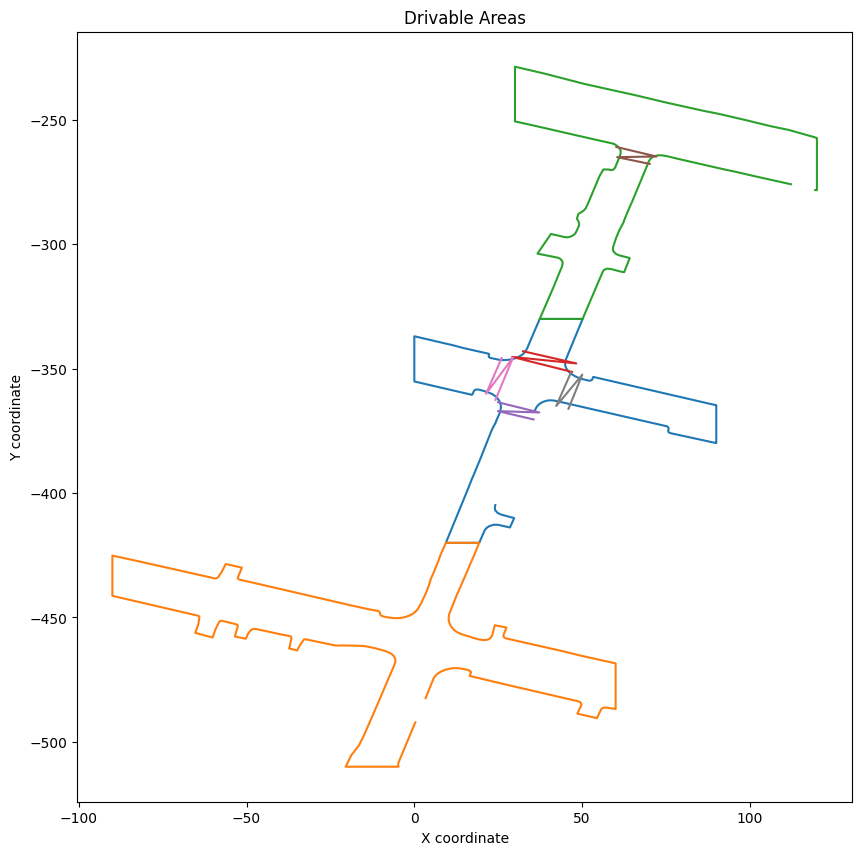

In [ ]:
import json
import matplotlib.pyplot as plt

# Load JSON data
with open('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/log_map_archive_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.json', 'r') as f:
    json_data = json.load(f)


# Assuming `json_data` has been loaded as shown previously
drivable_areas = json_data['drivable_areas']

# Plotting the drivable areas
plt.figure(figsize=(10, 10))

for area_id, area_info in drivable_areas.items():
    boundary = area_info['area_boundary']
    x = [point['x'] for point in boundary]
    y = [point['y'] for point in boundary]
    plt.plot(x, y, label=f'Area {area_id}')
# Assuming `json_data` has been loaded as shown previously
pedestrian_crossings = json_data['pedestrian_crossings']



x,y=[],[]
for area_id in pedestrian_crossings.keys():
    area_info = pedestrian_crossings[area_id]
    for obj in area_info['edge1']:
        x.append(obj['x'])
        y.append(obj['y'])

    for obj in area_info['edge2']:
        x.append(obj['x'])
        y.append(obj['y'])

    plt.plot(x, y, label=f'Pedestrain {area_id} edge1&2')
    x,y=[],[]

plt.title("Drivable Areas")
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend().set_visible(False)
plt.show()




In [ ]:
df['track_id'][0]

'50513'

In [ ]:
list_of_scenarios=os.listdir('/argotrain/train/')

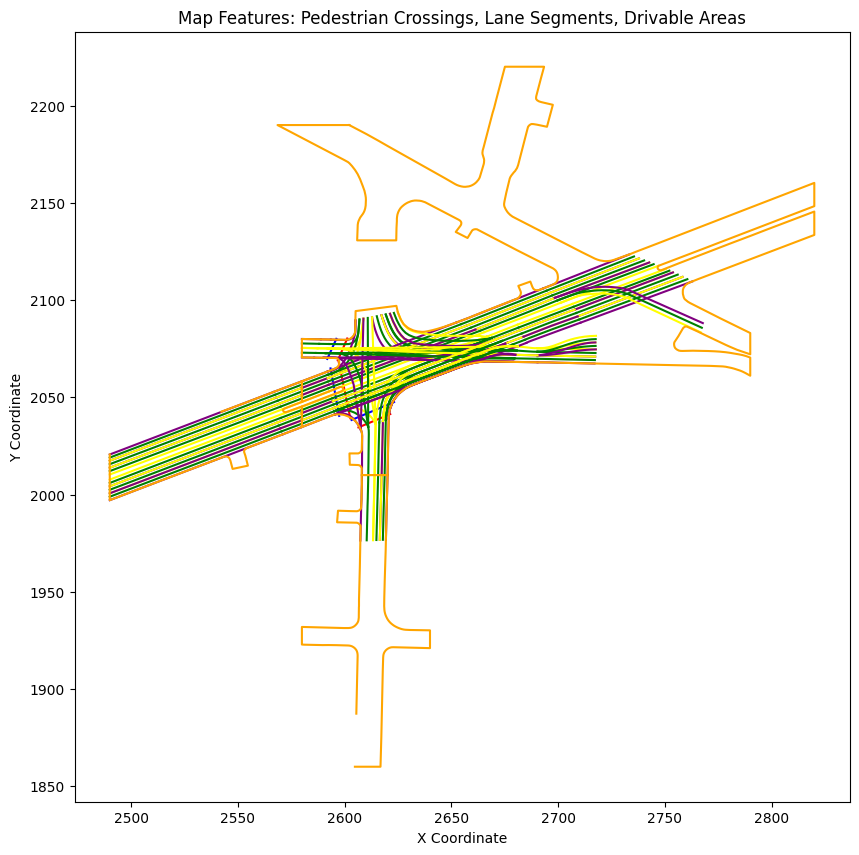

In [ ]:
import json
import matplotlib.pyplot as plt
index=1

# Load the map data from JSON
with open('/argotrain/train/'+list_of_scenarios[index]+'/log_map_archive_'+list_of_scenarios[index]+'.json', 'r') as f:
    json_data = json.load(f)


# Extract pedestrian crossings
pedestrian_crossings = json_data['pedestrian_crossings']
lane_segments = json_data['lane_segments']
drivable_areas = json_data['drivable_areas']

# Plot pedestrian crossings
plt.figure(figsize=(10, 10))
for area_id in pedestrian_crossings.keys():
    area_info = pedestrian_crossings[area_id]
    edge1 = area_info['edge1']
    edge2 = area_info['edge2']
    x_edge1 = [point['x'] for point in edge1]
    y_edge1 = [point['y'] for point in edge1]
    x_edge2 = [point['x'] for point in edge2]
    y_edge2 = [point['y'] for point in edge2]

    plt.plot(x_edge1, y_edge1, color='blue', label=f'Pedestrian Crossing {area_id} Edge 1')
    plt.plot(x_edge2, y_edge2, color='red', label=f'Pedestrian Crossing {area_id} Edge 2')

# Plot lane segments and boundaries
for lane_id, lane_info in lane_segments.items():
    centerline = lane_info['centerline']
    x_centerline = [point['x'] for point in centerline]
    y_centerline = [point['y'] for point in centerline]
    plt.plot(x_centerline, y_centerline, color='green', label=f'Lane {lane_id} Centerline')

    left_boundary = lane_info['left_lane_boundary']
    right_boundary = lane_info['right_lane_boundary']

    x_left = [point['x'] for point in left_boundary]
    y_left = [point['y'] for point in left_boundary]
    plt.plot(x_left, y_left, color='yellow', label=f'Lane {lane_id} Left Boundary')

    x_right = [point['x'] for point in right_boundary]
    y_right = [point['y'] for point in right_boundary]
    plt.plot(x_right, y_right, color='purple', label=f'Lane {lane_id} Right Boundary')

# Plot drivable areas
for area_id, area_info in drivable_areas.items():
    boundary = area_info['area_boundary']
    x_boundary = [point['x'] for point in boundary]
    y_boundary = [point['y'] for point in boundary]
    plt.plot(x_boundary, y_boundary, color='orange', label=f'Drivable Area {area_id}')

# Finalize plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('Map Features: Pedestrian Crossings, Lane Segments, Drivable Areas')
plt.legend().set_visible(False)
# Save the map as an image for future use
plt.savefig('map_image.png')

plt.show()


Encoded Map Vector: torch.Size([1, 768])


In [ ]:

# Load JSON file

for i in range(20):
    with open('/argotrain/train/'+list_of_scenarios[index]+'/log_map_archive_'+list_of_scenarios[index]+'.json', 'r') as f:
        map_data = json.load(f)

    # Convert JSON to text
    map_text = json_to_text(map_data)

    # Encode map text using Longformer
    map_vector = encode_map_text_with_longformer(map_text)

    # Print the dense representation
    print("Encoded Map Vector:", map_vector.shape)  # [1, Hidden Size]


Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])
Encoded Map Vector: torch.Size([1, 768])


In [ ]:
# Convert JSON to text
map_text = json_to_text(map_data)
print(map_text)

### Drivable Areas ###

Drivable Area ID: 22609356
Boundary Points:
  - (x: 24.14, y: -404.83, z: 4.04)
  - (x: 23.99, y: -405.79, z: 4.0)
  - (x: 24.09, y: -406.88, z: 3.95)
  - (x: 24.86, y: -408.01, z: 3.94)
  - (x: 26.08, y: -408.73, z: 3.98)
  - (x: 29.76, y: -410.04, z: 4.13)
  - (x: 28.51, y: -413.83, z: 3.98)
  - (x: 24.96, y: -412.76, z: 3.8)
  - (x: 23.66, y: -412.72, z: 3.71)
  - (x: 22.36, y: -413.28, z: 3.64)
  - (x: 21.57, y: -413.96, z: 3.55)
  - (x: 21.0, y: -414.88, z: 3.5)
  - (x: 19.34, y: -420.0, z: 3.21)
  - (x: 9.4, y: -420.0, z: 2.62)
  - (x: 15.85, y: -398.82, z: 3.67)
  - (x: 17.16, y: -394.32, z: 3.84)
  - (x: 17.6, y: -393.02, z: 3.86)
  - (x: 19.91, y: -385.47, z: 4.19)
  - (x: 22.94, y: -375.13, z: 4.47)
  - (x: 23.52, y: -373.44, z: 4.49)
  - (x: 24.19, y: -371.79, z: 4.53)
  - (x: 24.63, y: -370.29, z: 4.54)
  - (x: 25.28, y: -368.38, z: 4.59)
  - (x: 25.61, y: -367.03, z: 4.64)
  - (x: 25.8, y: -365.72, z: 4.56)
  - (x: 25.78, y: -364.76, z: 4.54)
  - (x

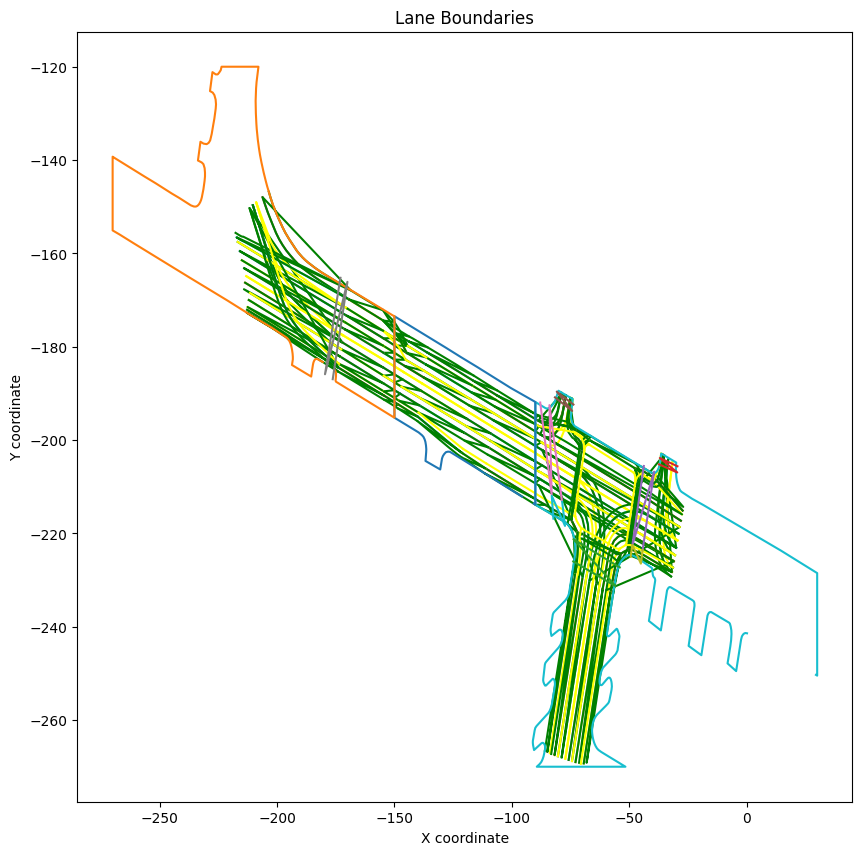

<class 'str'>


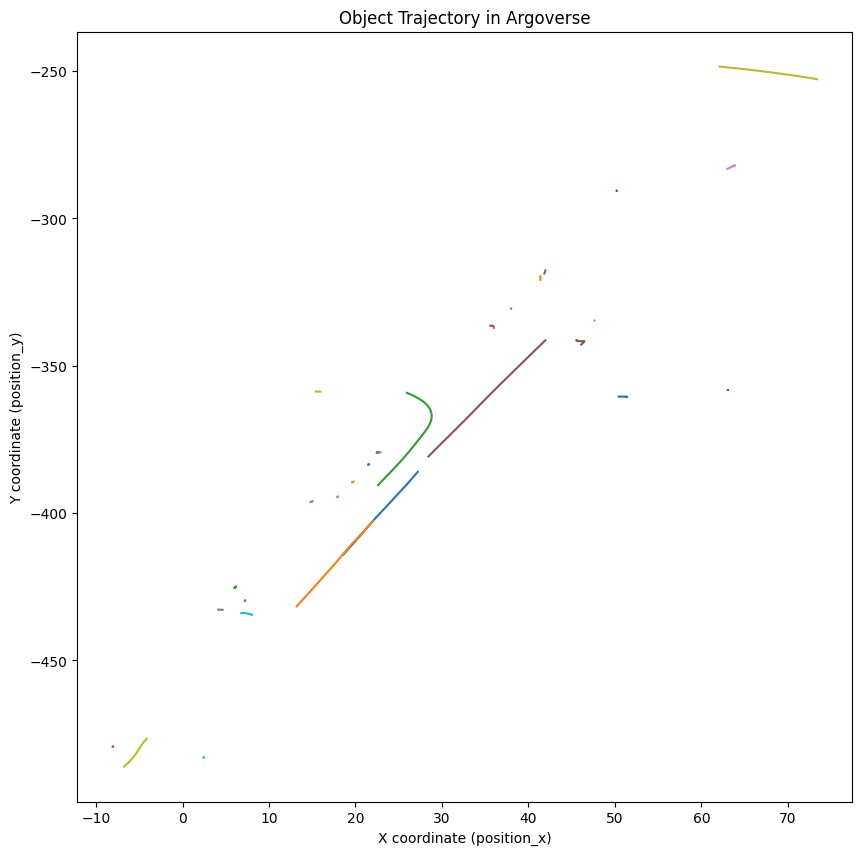

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Load JSON data
index=0
with open('/argotrain/train/'+list_of_scenarios[index]+'/log_map_archive_'+list_of_scenarios[index]+'.json', 'r') as f:
    json_data = json.load(f)


# Assuming `
plt.figure(figsize=(10, 10))
for lane_segment in json_data['lane_segments'].keys():
  x,y=[],[]
  for centerline in json_data['lane_segments'][lane_segment]['centerline']:
    x.append(centerline['x'])
    y.append(centerline['y'])
  plt.plot(x, y, label=f'Lane Segment {lane_segment}')
  for lane_boundary in json_data['lane_segments'][lane_segment]['right_lane_boundary']:
       x.append(lane_boundary['x'])
       y.append(lane_boundary['y'])
  plt.plot(x, y, color='green', label=f'right_lane_boundary {lane_segment}')
  x,y=[],[]
  for lane_boundary in json_data['lane_segments'][lane_segment]['left_lane_boundary']:
       x.append(lane_boundary['x'])
       y.append(lane_boundary['y'])
  plt.plot(x, y, color='yellow',label=f'left_lane_boundary {lane_segment}')
  x,y=[],[]

drivable_areas = json_data['drivable_areas']
for area_id, area_info in drivable_areas.items():
    boundary = area_info['area_boundary']
    x = [point['x'] for point in boundary]
    y = [point['y'] for point in boundary]
    plt.plot(x, y, label=f'Area {area_id}')
# Assuming `json_data` has been loaded as shown previously
pedestrian_crossings = json_data['pedestrian_crossings']



x,y=[],[]
for area_id in pedestrian_crossings.keys():
    area_info = pedestrian_crossings[area_id]
    for obj in area_info['edge1']:
        x.append(obj['x'])
        y.append(obj['y'])

    for obj in area_info['edge2']:
        x.append(obj['x'])
        y.append(obj['y'])

    plt.plot(x, y, label=f'Pedestrain {area_id} edge1&2')
    x,y=[],[]

plt.title("Lane Boundaries")
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.legend().set_visible(False)
plt.savefig(list_of_scenarios[index]+'.png')
plt.show()



df = pd.read_parquet('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet')
current_id=df['track_id'][0]

plt.figure(figsize=(10, 10))

x,y=[],[]
print(type(current_id))
object_type=df['object_type'][0]
for tracked_object in df.itertuples():
  #print(type(tracked_object['track_id']))
  if(tracked_object.observed):
      if(tracked_object.track_id ==  current_id ):
        x.append(tracked_object.position_x)
        y.append(tracked_object.position_y)
      else:

        plt.plot(x, y, label=f'object type: {object_type} ')
        current_id=tracked_object.track_id
        object_type=tracked_object.object_type
        x,y=[],[]

        if(tracked_object.track_id ==  'AV'):
          break


plt.title("Object Trajectory in Argoverse")
plt.xlabel('X coordinate (position_x)')
plt.ylabel('Y coordinate (position_y)')
plt.legend()
plt.legend().set_visible(False)


plt.show()


In [ ]:
vfor tracked_object in df.itertuples():
  print(tracked_object)
  print(tracked_object.focal_track_id)
  print(tracked_object.track_id)
  break

Pandas(Index=0, observed=True, track_id='50513', object_type='vehicle', object_category=2, timestep=0, position_x=18.591603678451392, position_y=-414.0758772545171, heading=1.2690809831899603, velocity_x=1.8893249539752826, velocity_y=6.052012605163476, scenario_id='0000b0f9-99f9-4a1f-a231-5be9e4c523f7', start_timestamp=3.15974224410163e+17, end_timestamp=3.15974235310163e+17, num_timestamps=110, focal_track_id='51241', city='austin')
51241
50513


In [ ]:
list_of_scenarios=os.listdir('/argotrain/train')

In [ ]:
list_of_scenarios[0:10]

['03190276-a94a-4899-815d-8a132370395d',
 'd9a9bc77-9cb9-4af5-9667-aa3ad8b40d76',
 'f2caced2-17b8-4254-908e-5ba2e01d3093',
 '1b43a4d0-05a2-47fe-8dfd-5ce6f69e2d69',
 'd1a132ad-a4e8-478b-ab07-80552c28f0bc',
 '7545e384-68c5-4313-ac1f-62efc2adbb28',
 '596d289a-19f5-42db-ac43-3e1d43082a92',
 'e3772143-9854-40da-8347-d56d7bad8dcd',
 'e2594dff-72ff-49b1-8378-c3b1d01fe7c4',
 'd96f090f-5c19-46bd-81f6-934fc9dfc0f6']

In [ ]:
len(list_of_scenarios)

199908

In [ ]:
os.listdir('/argotrain/train/'+list_of_scenarios[0])

['scenario_03190276-a94a-4899-815d-8a132370395d.parquet',
 'log_map_archive_03190276-a94a-4899-815d-8a132370395d.json']

### Aanalyzing our scenarios

In [ ]:
import pandas as pd
avg_cnt = 0
num_of_scenarios = 0
total_count = 0

for i in range(len(list_of_scenarios)-1):
    # Load the parquet file for the current scenario
    df = pd.read_parquet('/argotrain/train/' + list_of_scenarios[i] + '/scenario_' + list_of_scenarios[i] + '.parquet')

    # Count the number of unique objects (track_id) in the current scenario
    count = len(df['track_id'].unique())

    if count > 200:
        print(f"Scenario {list_of_scenarios[i]} has {count} objects (more than 200).")

    total_count += count
    num_of_scenarios += 1

    # Print the average every 100 scenarios
    if num_of_scenarios % 100 == 0:
        avg_cnt = total_count / num_of_scenarios
        print(f'Average number of objects after {num_of_scenarios} scenarios: {avg_cnt}')
        print(f'Total scenarios processed: {num_of_scenarios}')
        print('\n')

# Print the final average at the end of the loop
if num_of_scenarios > 0:
    final_avg_cnt = total_count / num_of_scenarios
    print(f'Final average number of objects across all scenarios: {final_avg_cnt}')
    print(f'Total number of scenarios processed: {num_of_scenarios}')


Streaming output truncated to the last 5000 lines.


Average number of objects after 75700 scenarios: 55.5808322324967
Total scenarios processed: 75700


Average number of objects after 75800 scenarios: 55.58006596306068
Total scenarios processed: 75800


Average number of objects after 75900 scenarios: 55.57528326745718
Total scenarios processed: 75900


Average number of objects after 76000 scenarios: 55.581276315789474
Total scenarios processed: 76000


Average number of objects after 76100 scenarios: 55.57931668856767
Total scenarios processed: 76100


Average number of objects after 76200 scenarios: 55.578792650918636
Total scenarios processed: 76200


Average number of objects after 76300 scenarios: 55.57777195281783
Total scenarios processed: 76300


Average number of objects after 76400 scenarios: 55.5763612565445
Total scenarios processed: 76400


Average number of objects after 76500 scenarios: 55.57943790849673
Total scenarios processed: 76500


Average number of objects aft

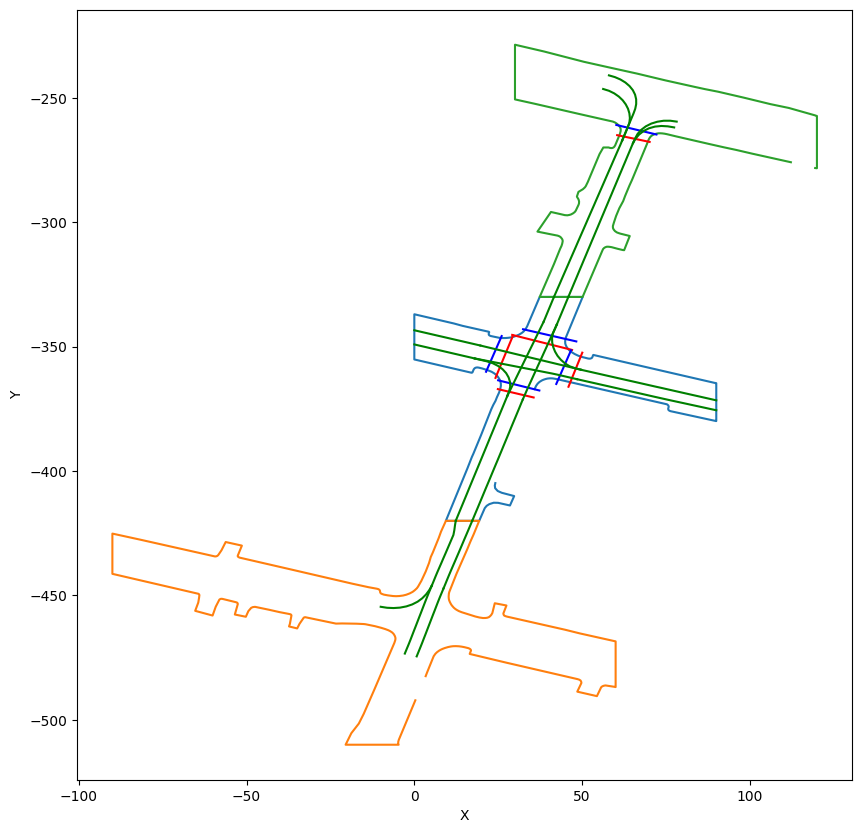

In [ ]:
with open('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/log_map_archive_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.json', 'r') as f:
        json_data = json.load(f)

        plt.figure(figsize=(10, 10))

        # Ploting drivable areas
        for area_id, area_info in json_data['drivable_areas'].items():
            boundary = area_info['area_boundary']
            x = [point['x'] for point in boundary]
            y = [point['y'] for point in boundary]
            plt.plot(x, y, label=f'Area {area_id}')

        # Ploting pedestrian crossings
        for crossing_id, crossing_info in json_data['pedestrian_crossings'].items():
            edge1 = crossing_info['edge1']
            edge2 = crossing_info['edge2']
            x1 = [point['x'] for point in edge1]
            y1 = [point['y'] for point in edge1]
            x2 = [point['x'] for point in edge2]
            y2 = [point['y'] for point in edge2]
            plt.plot(x1, y1, label=f'Pedestrian {crossing_id} edge1', color='blue')
            plt.plot(x2, y2, label=f'Pedestrian {crossing_id} edge2', color='red')

        # Ploting lane segments
        for lane_id, lane_info in json_data['lane_segments'].items():
            centerline = lane_info['centerline']
            x = [point['x'] for point in centerline]
            y = [point['y'] for point in centerline]
            plt.plot(x, y, label=f'Lane {lane_id} centerline', color='green')

        # Save the HD map image
        #hd_map_image_path = os.path.join(output_dir, f"{scenario_id}_hd_map.png")
        #plt.title(f"HD Map for Scenario {scenario_id}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend().set_visible(False)
        plt.show()
        #plt.savefig(hd_map_image_path)
        #plt.close()

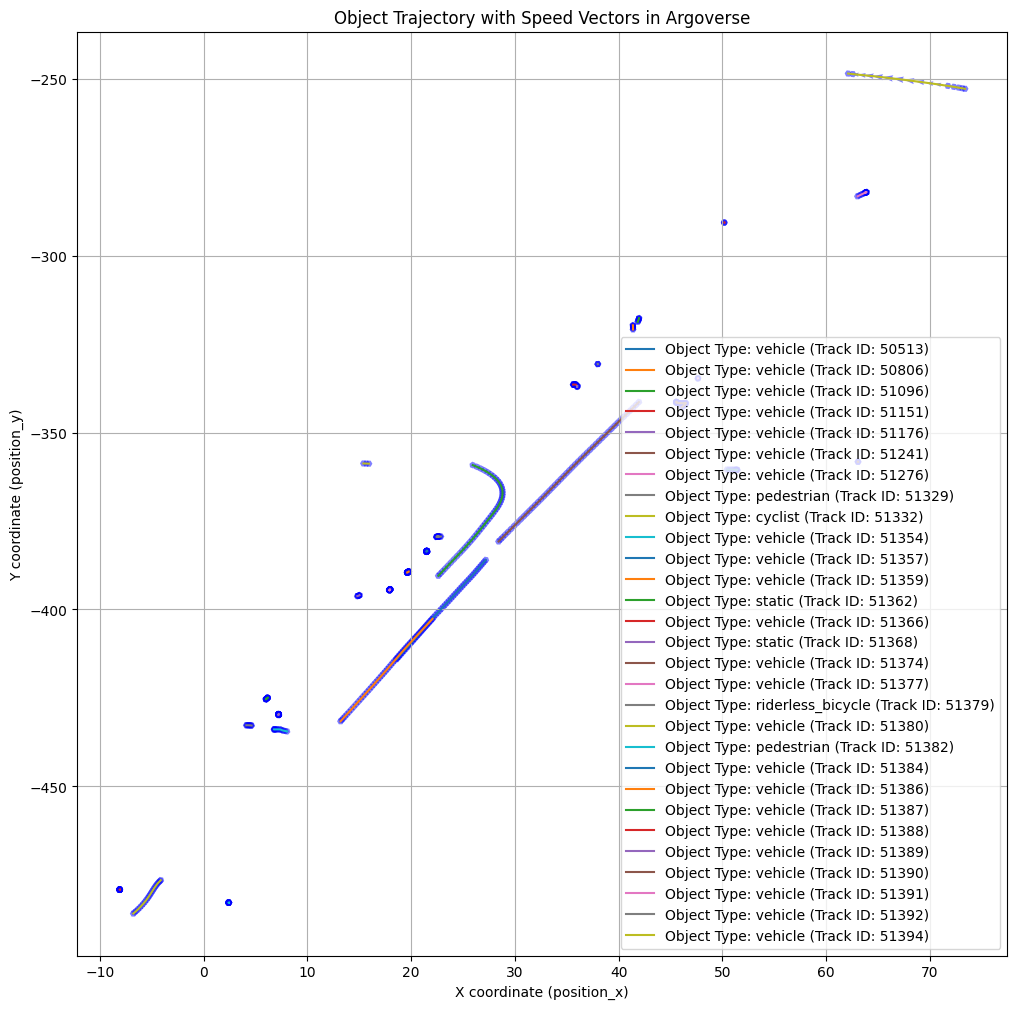

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Parquet data
df = pd.read_parquet('/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet')
current_id = df['track_id'][0]

# Initialize lists for positions and speeds
x, y, vx, vy = [], [], [], []
previous_x, previous_y = None, None

# Initialize figure
plt.figure(figsize=(12, 12))

# Get object type for the first object
object_type = df['object_type'][0]

for tracked_object in df.itertuples():
    # Check if the object is observed and belongs to the same track
    if tracked_object.observed:
        if tracked_object.track_id == current_id:
            # Append positions
            x.append(tracked_object.position_x)
            y.append(tracked_object.position_y)

            # Calculate and append speed if previous position is available
            if previous_x is not None and previous_y is not None:
                vx.append(tracked_object.position_x - previous_x)
                vy.append(tracked_object.position_y - previous_y)
            else:
                # Initial speed for the first point (set to 0)
                vx.append(0)
                vy.append(0)

            # Update previous position
            previous_x, previous_y = tracked_object.position_x, tracked_object.position_y

        else:
            # Plot the trajectory and speeds
            plt.quiver(x, y, vx, vy, angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
            plt.plot(x, y, label=f'Object Type: {object_type} (Track ID: {current_id})')

            # Reset for the next object
            current_id = tracked_object.track_id
            object_type = tracked_object.object_type
            x, y, vx, vy = [], [], [], []
            previous_x, previous_y = None, None

            # If the track ID is 'AV', stop plotting (optional condition)
            if tracked_object.track_id == 'AV':
                break

# Set plot title and labels
plt.title("Object Trajectory with Speed Vectors in Argoverse")
plt.xlabel('X coordinate (position_x)')
plt.ylabel('Y coordinate (position_y)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Number of Scenarios

In [ ]:
len(list_of_scenarios)

199908

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
all_data = pd.DataFrame()
all_data_json= pd.DataFrame()
scenario_count=0
# Define the path to the directory containing the Parquet files
for scenario in list_of_scenarios:
   if(scenario_count>4000):
    break

   parquet_dir = '/argotrain/train/'+scenario+'/'
   for filename in os.listdir(parquet_dir):
        if filename.endswith('.parquet'):
            file_path = os.path.join(parquet_dir, filename)

            # Load the Parquet data
            df = pd.read_parquet(file_path)

            # Append the data to all_data DataFrame
            all_data = pd.concat([all_data, df], ignore_index=True)
        if filename.endswith('.json'):
            file_path = os.path.join(parquet_dir, filename)

            # Load the JSON data
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                print(json_data.keys())
                all_data_json=pd.concat([all_data_json, json_data], ignore_index=True)
   scenario_count= scenario_count+1




In [ ]:
len(all_data)

12473548

In [ ]:
len(all_data['track_id'].unique())

134717

### Out of 199,908 scenarios

In [ ]:
len(all_data['scenario_id'].unique())

4315

In [ ]:

city_counts_per_track = all_data.groupby(['track_id', 'city'])['scenario_id'].nunique()

# Print the results
print(city_counts_per_track)


track_id  city         
1         austin              2
          miami               1
          palo-alto           1
          pittsburgh          2
10        austin              1
                           ... 
AV        dearborn          533
          miami            1150
          palo-alto         229
          pittsburgh        949
          washington-dc     549
Name: scenario_id, Length: 205093, dtype: int64


In [ ]:
all_data['city'].unique()

array(['pittsburgh', 'dearborn', 'washington-dc', 'miami', 'austin',
       'palo-alto'], dtype=object)

In [ ]:
all_data.shape

(12473548, 16)

In [ ]:
all_data.keys()

Index(['observed', 'track_id', 'object_type', 'object_category', 'timestep',
       'position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y',
       'scenario_id', 'start_timestamp', 'end_timestamp', 'num_timestamps',
       'focal_track_id', 'city'],
      dtype='object')

In [ ]:
print(all_data['num_timestamps'].unique())

1
[110]


In [ ]:
# prompt: give me the number of observed vs unobserved Data points

observed_data_count = all_data[all_data['observed'] == True].shape[0]
unobserved_data_count = all_data[all_data['observed'] == False].shape[0]

print(f"Number of observed data points: {observed_data_count}")
print(f"Number of unobserved data points: {unobserved_data_count}")


Number of observed data points: 5596936
Number of unobserved data points: 6876612


In [ ]:
all_data['object_type'].unique()

array(['vehicle', 'background', 'static', 'unknown', 'pedestrian', 'bus',
       'riderless_bicycle', 'construction', 'cyclist', 'motorcyclist'],
      dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder


In [ ]:
all_data['position_x'].mean()

2938.1242616314453

In [ ]:
print(all_data['position_x'].mean())
print(all_data['position_x'].max())
print(all_data['position_x'].min())


print(all_data['position_y'].mean())
print(all_data['position_y'].max())
print(all_data['position_y'].min())

2938.1242616314453
13310.821612586691
-9168.650426166925
1109.3530998311205
6390.111467561734
-4605.119036924746


##For HD Maps

In [ ]:
json_data.keys()

dict_keys(['drivable_areas', 'lane_segments', 'pedestrian_crossings'])

In [ ]:
json_data['drivable_areas'].keys()

dict_keys(['22609356', '22609575', '22610080'])

In [ ]:
json_data['drivable_areas']['22609356']

In [ ]:
json_data['lane_segments'].keys()

dict_keys(['390752190', '390752347', '390752410', '390752443', '390752826', '390753409', '390753560', '390753588', '390753606', '390753616', '390753629', '390753644', '390753746', '390753759', '390753779', '390753780', '390753792', '390753956', '390753966', '390753968', '390753973', '390754008', '390754196', '390754454', '390754530'])

In [ ]:
json_data['lane_segments']['390752190']

{'centerline': [{'x': 8.7, 'y': -447.17, 'z': 0.0},
  {'x': 9.26, 'y': -445.36, 'z': 0.0},
  {'x': 9.81, 'y': -443.54, 'z': 0.0},
  {'x': 10.37, 'y': -441.72, 'z': 0.0},
  {'x': 10.94, 'y': -439.91, 'z': 0.0},
  {'x': 11.52, 'y': -438.1, 'z': 0.0},
  {'x': 12.1, 'y': -436.3, 'z': 0.0},
  {'x': 12.68, 'y': -434.49, 'z': 0.0},
  {'x': 13.26, 'y': -432.68, 'z': 0.0},
  {'x': 13.83, 'y': -430.87, 'z': 0.0},
  {'x': 14.4, 'y': -429.06, 'z': 0.0},
  {'x': 14.97, 'y': -427.24, 'z': 0.0},
  {'x': 15.55, 'y': -425.43, 'z': 0.0},
  {'x': 16.12, 'y': -423.62, 'z': 0.0},
  {'x': 16.69, 'y': -421.81, 'z': 0.0},
  {'x': 17.26, 'y': -420.0, 'z': 0.0}],
 'id': 390752190,
 'is_intersection': False,
 'lane_type': 'VEHICLE',
 'left_lane_boundary': [{'x': 6.75, 'y': -446.58, 'z': 1.48},
  {'x': 15.09, 'y': -420.33, 'z': 3.07},
  {'x': 15.1, 'y': -420.3, 'z': 3.07},
  {'x': 15.14, 'y': -420.16, 'z': 3.07},
  {'x': 15.15, 'y': -420.13, 'z': 3.07},
  {'x': 15.16, 'y': -420.08, 'z': 3.07},
  {'x': 15.18, 'y':

In [ ]:
json_data['pedestrian_crossings'].keys()

dict_keys(['24116923', '24116997', '24117092', '24117137', '24117312'])

In [ ]:
json_data['pedestrian_crossings']['24116923']

{'edge1': [{'x': 32.41, 'y': -342.98, 'z': 4.82},
  {'x': 48.28, 'y': -347.88, 'z': 5.75}],
 'edge2': [{'x': 29.17, 'y': -345.26, 'z': 4.76},
  {'x': 47.01, 'y': -351.3, 'z': 5.78}],
 'id': 24116923}

In [ ]:
# prompt: lets print all the keys, one sample, unless it has keys then we print the keys that the key has

for key in json_data.keys():
  print(f"Key: {key}")
  if isinstance(json_data[key], dict):
    sample_key = list(json_data[key].keys())[0]
    print(f"  Sample Key: {sample_key}")
    if isinstance(json_data[key][sample_key], dict):
      print(f"    Inner Keys: {json_data[key][sample_key].keys()}")
  else:
    print(f"  Sample Value: {json_data[key][:20]}")


Key: drivable_areas
  Sample Key: 22609356
    Inner Keys: dict_keys(['area_boundary', 'id'])
Key: lane_segments
  Sample Key: 390752190
    Inner Keys: dict_keys(['centerline', 'id', 'is_intersection', 'lane_type', 'left_lane_boundary', 'left_lane_mark_type', 'left_neighbor_id', 'predecessors', 'right_lane_boundary', 'right_lane_mark_type', 'right_neighbor_id', 'successors'])
Key: pedestrian_crossings
  Sample Key: 24116923
    Inner Keys: dict_keys(['edge1', 'edge2', 'id'])


'pedestrian_crossings'

In [ ]:
def print_keys(json_data):
  if isinstance(json_data, dict):
    for key in json_data.keys():
      print(f"Key: {key}")
      if isinstance(json_data[key], dict):
        print_keys(json_data[key])
      else:
        print(f"  Sample Value: {json_data[key]}")
print_keys(json_data)

Key: drivable_areas
Key: 22609356
Key: area_boundary
  Sample Value: [{'x': 24.14, 'y': -404.83, 'z': 4.04}, {'x': 23.99, 'y': -405.79, 'z': 4.0}, {'x': 24.09, 'y': -406.88, 'z': 3.95}, {'x': 24.86, 'y': -408.01, 'z': 3.94}, {'x': 26.08, 'y': -408.73, 'z': 3.98}, {'x': 29.76, 'y': -410.04, 'z': 4.13}, {'x': 28.51, 'y': -413.83, 'z': 3.98}, {'x': 24.96, 'y': -412.76, 'z': 3.8}, {'x': 23.66, 'y': -412.72, 'z': 3.71}, {'x': 22.36, 'y': -413.28, 'z': 3.64}, {'x': 21.57, 'y': -413.96, 'z': 3.55}, {'x': 21.0, 'y': -414.88, 'z': 3.5}, {'x': 19.34, 'y': -420.0, 'z': 3.21}, {'x': 9.4, 'y': -420.0, 'z': 2.62}, {'x': 15.85, 'y': -398.82, 'z': 3.67}, {'x': 17.16, 'y': -394.32, 'z': 3.84}, {'x': 17.6, 'y': -393.02, 'z': 3.86}, {'x': 19.91, 'y': -385.47, 'z': 4.19}, {'x': 22.94, 'y': -375.13, 'z': 4.47}, {'x': 23.52, 'y': -373.44, 'z': 4.49}, {'x': 24.19, 'y': -371.79, 'z': 4.53}, {'x': 24.63, 'y': -370.29, 'z': 4.54}, {'x': 25.28, 'y': -368.38, 'z': 4.59}, {'x': 25.61, 'y': -367.03, 'z': 4.64}, {'x

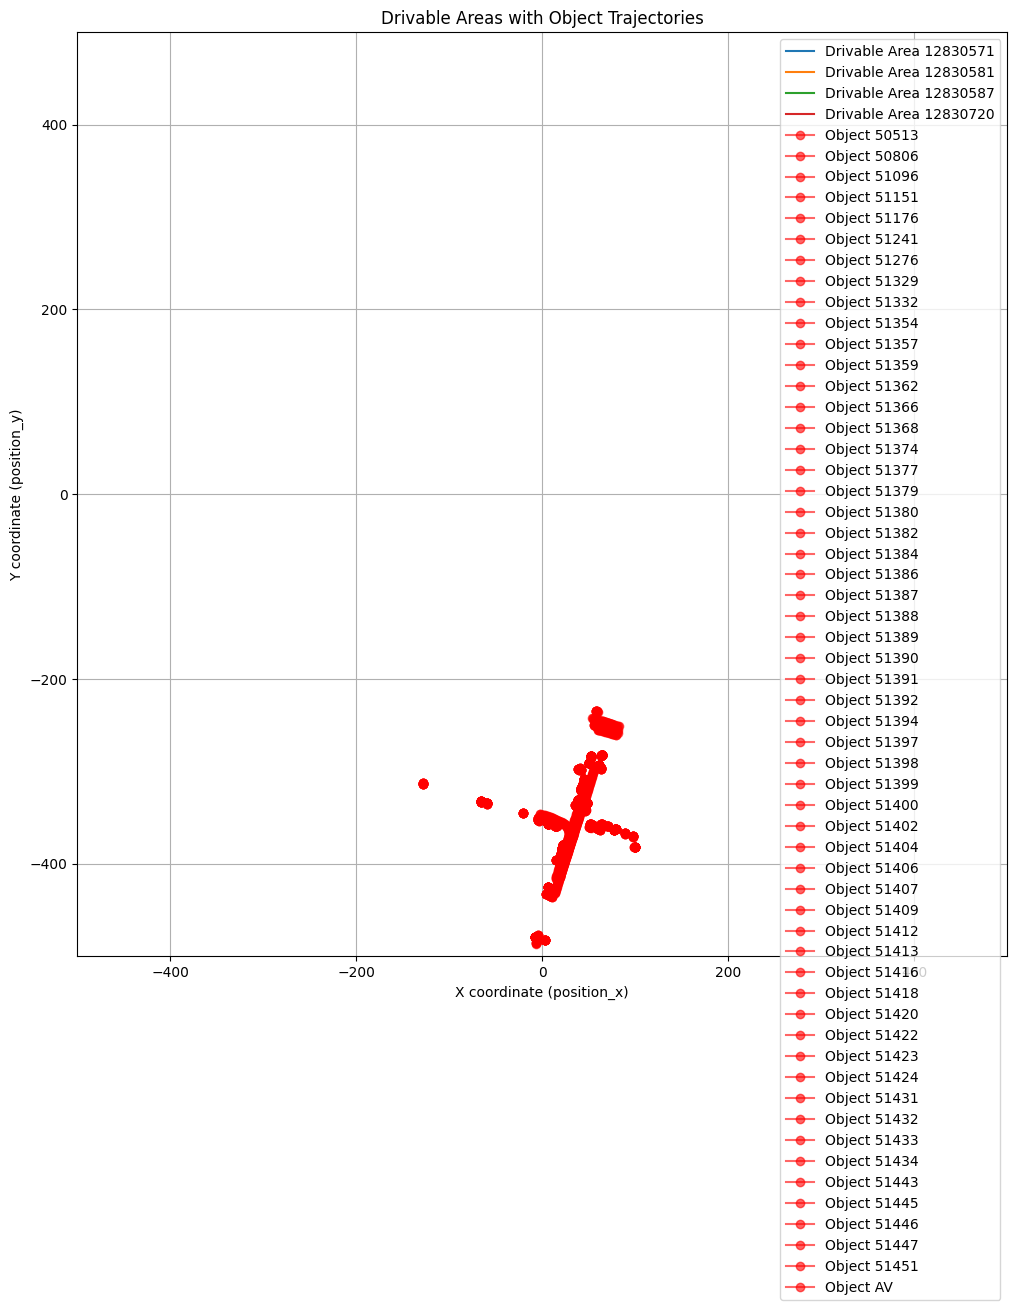

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt


# Extract drivable areas
drivable_areas = json_data['drivable_areas']

# Initialize the plot
plt.figure(figsize=(12, 12))

# Plot drivable areas from the JSON data
for area_id, area_info in drivable_areas.items():
    boundary = area_info['area_boundary']
    x = [point['x'] for point in boundary]
    y = [point['y'] for point in boundary]
    plt.plot(x, y, label=f'Drivable Area {area_id}')

# Plot object trajectories from the CSV/Parquet file
# Ensure the correct track_id, here we're just plotting a general set of points
for track_id in df['track_id'].unique():
    trajectory = df[df['track_id'] == track_id]
    plt.plot(trajectory['position_x'], trajectory['position_y'], 'ro-', label=f'Object {track_id}', alpha=0.6)

# Zoom in on a specific region (optional)
plt.xlim(-500, 500)  # Adjust according to your data
plt.ylim(-500, 500)  # Adjust according to your data

# Aesthetics: Adding labels, title, and legend
plt.title("Drivable Areas with Object Trajectories")
plt.xlabel('X coordinate (position_x)')
plt.ylabel('Y coordinate (position_y)')
plt.legend(loc="best")
plt.grid(True)  # Adding grid lines for better visualization

# Show the plot
plt.show()


In [ ]:
df['heading'].unique()

2440

In [ ]:
df.keys()

Index(['observed', 'track_id', 'object_type', 'object_category', 'timestep',
       'position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y',
       'scenario_id', 'start_timestamp', 'end_timestamp', 'num_timestamps',
       'focal_track_id', 'city'],
      dtype='object')

In [ ]:
len(all_data['position_x'].unique())

12469741

In [ ]:
df.keys()

Index(['observed', 'track_id', 'object_type', 'object_category', 'timestep',
       'position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y',
       'scenario_id', 'start_timestamp', 'end_timestamp', 'num_timestamps',
       'focal_track_id', 'city'],
      dtype='object')

In [ ]:
df.head()

,observed,track_id,object_type,object_category,timestep,position_x,position_y,heading,velocity_x,velocity_y,scenario_id,start_timestamp,end_timestamp,num_timestamps,focal_track_id,city
0,True,50513,vehicle,2,0,18.591604,-414.075877,1.269081,1.889325,6.052013,0000b0f9-99f9-4a1f-a231-5be9e4c523f7,3.159742e+17,3.159742e+17,110,51241,austin
1,True,50513,vehicle,2,1,18.693685,-413.747185,1.268987,1.898718,6.062060,0000b0f9-99f9-4a1f-a231-5be9e4c523f7,3.159742e+17,3.159742e+17,110,51241,austin
2,True,50513,vehicle,2,2,18.819566,-413.338909,1.268902,1.902845,6.048986,0000b0f9-99f9-4a1f-a231-5be9e4c523f7,3.159742e+17,3.159742e+17,110,51241,austin
3,True,50513,vehicle,2,3,18.967646,-412.857532,1.268811,1.890446,5.996844,0000b0f9-99f9-4a1f-a231-5be9e4c523f7,3.159742e+17,3.159742e+17,110,51241,austin
4,True,50513,vehicle,2,4,19.136512,-412.309115,1.268704,1.877703,5.958815,0000b0f9-99f9-4a1f-a231-5be9e4c523f7,3.159742e+17,3.159742e+17,110,51241,austin


from matplotlib import pyplot as plt
_df_0['timestep'].plot(kind='hist', bins=20, title='timestep')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['position_x'].plot(kind='hist', bins=20, title='position_x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['position_y'].plot(kind='hist', bins=20, title='position_y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['heading'].plot(kind='hist', bins=20, title='heading')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='timestep', y='position_x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='position_x', y='position_y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='position_y', y='heading', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='heading', y='velocity_x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['object_category']
  ys = series['heading']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('object_category', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('object_category')
_ = plt.ylabel('heading')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['object_category']
  ys = series['velocity_x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('object_category', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('object_category')
_ = plt.ylabel('velocity_x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['object_category']
  ys = series['velocity_y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('object_category', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('object_category')
_ = plt.ylabel('velocity_y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['object_category']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'object_category'}, axis=1)
              .sort_values('object_category', ascending=True))
  xs = counted['object_category']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('object_category', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('object_category')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['timestep'].plot(kind='line', figsize=(8, 4), title='timestep')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['position_x'].plot(kind='line', figsize=(8, 4), title='position_x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['position_y'].plot(kind='line', figsize=(8, 4), title='position_y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['heading'].plot(kind='line', figsize=(8, 4), title='heading')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# @title position_y vs heading

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='position_y', y='heading', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print(df['scenario_id'][0])
df['observed'][0]
df['heading'][0]

0000b0f9-99f9-4a1f-a231-5be9e4c523f7


1.2690809831899603

In [ ]:
def print_df(df,index,key):
  val=df[key][index]
  print('key is: '+key +' val is :'+str(val))

In [ ]:
for index in range(40):
  print('\n\n')
  for key in df.keys():
    if key != 'city' and key != 'observed' and key!='track_id' and key !='object_category':
      print_df(df,index,key)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load the scenario from parquet file
def load_scenario(parquet_path: Path):
    df = pd.read_parquet(parquet_path)
    return df

# Plot the trajectories of all tracks in the scenario
def plot_scenario(df, focal_track_id=None):
    plt.figure(figsize=(10, 10))

    # Iterate over each track_id in the dataset
    for track_id in df['track_id'].unique():
        track_df = df[df['track_id'] == track_id]

        # Plot trajectory for each track
        if track_id == focal_track_id:
            plt.plot(track_df['position_x'], track_df['position_y'], 'r-', label=f"Focal Track {track_id}")
        else:
            plt.plot(track_df['position_x'], track_df['position_y'], 'b-', alpha=0.6)

    plt.title(f"Scenario Visualization")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
scenario_path = Path("/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet")
scenario_df = load_scenario(scenario_path)

# Assuming 'focal_track_id' is stored in the dataframe
focal_track_id = scenario_df['focal_track_id'].iloc[0]
plot_scenario(scenario_df, focal_track_id=focal_track_id)
for track_id in df['track_id'].unique():
  plot_scenario(scenario_df, focal_track_id=track_id)


In [ ]:
for track_id in df['track_id'].unique():
  if(track_id=='51241'):
    print(df[df['track_id'] == track_id]['observed'])
    print(df[df['track_id'] == track_id]['timestep'])
    print(df[df['track_id'] == track_id]['scenario_id'])
    print(df[df['track_id'] == track_id]['track_id'])
    print(df[df['track_id'] == track_id]['position_x'])
    print(df[df['track_id'] == track_id]['position_y'])
    print(df[df['track_id'] == track_id]['heading'])
    print(df[df['track_id'] == track_id]['velocity_x'])
    print(df[df['track_id'] == track_id]['velocity_y'])
    print(df[df['track_id'] == track_id]['object_type'])

In [ ]:
df.head()

In [ ]:
scenario_df['observed'][108:111]

,observed
108,False
109,False
110,True


In [ ]:
scenario_df['timestep'][108:111]

,timestep
108,108
109,109
110,0


In [ ]:
scenario_df['scenario_id'][108:111]

,scenario_id
108,0000b0f9-99f9-4a1f-a231-5be9e4c523f7
109,0000b0f9-99f9-4a1f-a231-5be9e4c523f7
110,0000b0f9-99f9-4a1f-a231-5be9e4c523f7


In [ ]:
scenario_df['track_id'][108:111]

,track_id
108,50513
109,50513
110,50806


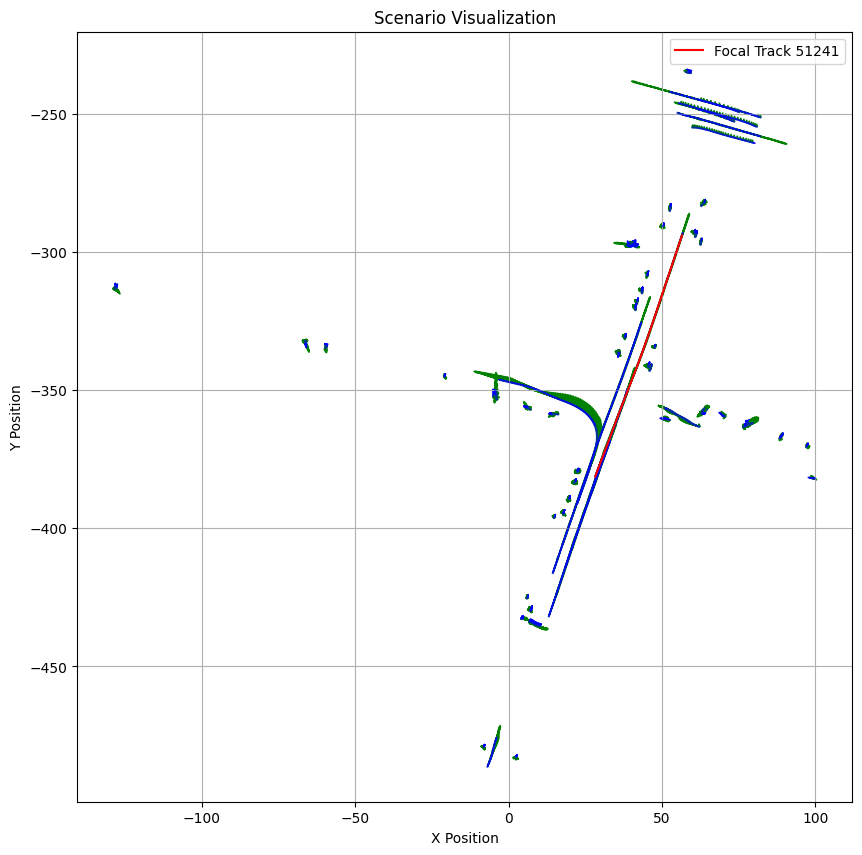

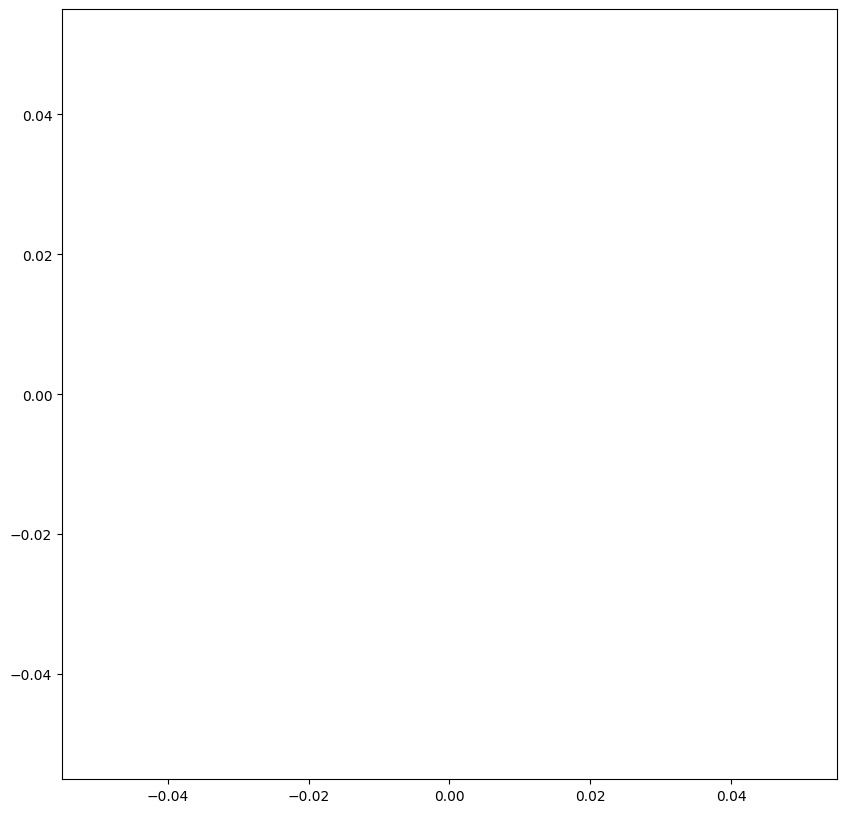

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch
from matplotlib.animation import FuncAnimation
from pathlib import Path

# Load the scenario from parquet file
def load_scenario(parquet_path: Path):
    df = pd.read_parquet(parquet_path)
    return df

# Plot heading and velocity arrows
def plot_arrows(df, ax):
    for idx, row in df.iterrows():
        start_x, start_y = row['position_x'], row['position_y']
        vel_x, vel_y = row['velocity_x'], row['velocity_y']
        heading = row['heading']

        # Plot velocity vector
        ax.arrow(start_x, start_y, vel_x, vel_y, head_width=0.5, head_length=1, fc='green', ec='green')

        # Plot heading arrow
        heading_length = 2.0
        ax.add_patch(FancyArrowPatch((start_x, start_y),
                                     (start_x + heading_length * np.cos(heading),
                                      start_y + heading_length * np.sin(heading)),
                                     color='blue', arrowstyle='->'))

# Function to plot scenario
def plot_scenario(df, focal_track_id=None, map_data=None):
    fig, ax = plt.subplots(figsize=(10, 10))

    # If map data (like drivable areas) is available, plot it
    if map_data is not None:
        ax.plot(map_data['x'], map_data['y'], 'k--', label='Map Data')

    # Iterate over each track_id in the dataset
    for track_id in df['track_id'].unique():
        track_df = df[df['track_id'] == track_id]

        # Plot trajectory for each track
        if track_id == focal_track_id:
            ax.plot(track_df['position_x'], track_df['position_y'], 'r-', label=f"Focal Track {track_id}")
        else:
            ax.plot(track_df['position_x'], track_df['position_y'], 'b-', alpha=0.6)

        # Plot velocity and heading arrows
        plot_arrows(track_df, ax)

    ax.set_title(f"Scenario Visualization")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    plt.grid(True)
    plt.show()

# Optional: Animation function for motion over time
def animate_scenario(df, focal_track_id=None, map_data=None):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot static map information
    if map_data is not None:
        ax.plot(map_data['x'], map_data['y'], 'k--', label='Map Data')

    focal_track = df[df['track_id'] == focal_track_id]
    other_tracks = df[df['track_id'] != focal_track_id]

    focal_line, = ax.plot([], [], 'ro-', label="Focal Track")
    other_lines = []

    for track_id in df['track_id'].unique():
        if track_id != focal_track_id:
            other_line, = ax.plot([], [], 'b-', alpha=0.6)
            other_lines.append(other_line)

    def init():
        focal_line.set_data([], [])
        for line in other_lines:
            line.set_data([], [])
        return [focal_line] + other_lines

    def update(frame):
        # Focal track updates
        focal_line.set_data(focal_track['position_x'].iloc[:frame], focal_track['position_y'].iloc[:frame])

        # Update other tracks
        for i, track_id in enumerate(df['track_id'].unique()):
            if track_id != focal_track_id:
                track_df = other_tracks[other_tracks['track_id'] == track_id]
                other_lines[i].set_data(track_df['position_x'].iloc[:frame], track_df['position_y'].iloc[:frame])

        return [focal_line] + other_lines

    ani = FuncAnimation(fig, update, frames=len(focal_track), init_func=init, blit=True, repeat=False)
    plt.show()

# Example usage:
scenario_path = Path("/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet")
scenario_df = load_scenario(scenario_path)

# If map data is available (in CSV or other format)
# map_data = pd.read_csv('path_to_map_file.csv')

focal_track_id = scenario_df['focal_track_id'].iloc[0]

# Plot with map data if available
plot_scenario(scenario_df, focal_track_id=focal_track_id, map_data=None)

# For animation (optional)
animate_scenario(scenario_df, focal_track_id=focal_track_id, map_data=None)


## The following is a quick run via Tensorflow, further down do we find the PyTorch implementation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from pathlib import Path


def load_scenario(parquet_path: Path):
    df = pd.read_parquet(parquet_path)
    return df


def plot_arrows(df, ax):
    for idx, row in df.iterrows():
        start_x, start_y = row['position_x'], row['position_y']
        vel_x, vel_y = row['velocity_x'], row['velocity_y']
        heading = row['heading']

        # Plot velocity vector
        ax.arrow(start_x, start_y, vel_x, vel_y, head_width=0.5, head_length=1, fc='green', ec='green')

        # Plot heading arrow
        heading_length = 2.0
        ax.add_patch(FancyArrowPatch((start_x, start_y),
                                     (start_x + heading_length * np.cos(heading),
                                      start_y + heading_length * np.sin(heading)),
                                     color='blue', arrowstyle='->'))

def animate_scenario(df, focal_track_id=None, map_data=None, save_path="animation.mp4"):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot static map information
    if map_data is not None:
        ax.plot(map_data['x'], map_data['y'], 'k--', label='Map Data')

    focal_track = df[df['track_id'] == focal_track_id]
    other_tracks = df[df['track_id'] != focal_track_id]

    focal_line, = ax.plot([], [], 'ro-', label="Focal Track")
    other_lines = []

    # Get unique other track IDs and initialize plot lines
    other_track_ids = other_tracks['track_id'].unique()
    for _ in other_track_ids:
        other_line, = ax.plot([], [], 'b-', alpha=0.6)
        other_lines.append(other_line)

    # Set plot limits based on the data
    ax.set_xlim(df['position_x'].min() , df['position_x'].max() )
    ax.set_ylim(df['position_y'].min() , df['position_y'].max() )

    def init():
        focal_line.set_data([], [])
        for line in other_lines:
            line.set_data([], [])
        return [focal_line] + other_lines

    def update(frame):
        # Focal track updates
        focal_line.set_data(focal_track['position_x'].iloc[:frame], focal_track['position_y'].iloc[:frame])

        # Update other tracks
        for i, track_id in enumerate(other_track_ids):
            track_df = other_tracks[other_tracks['track_id'] == track_id]
            if len(track_df) > 0:
                other_lines[i].set_data(track_df['position_x'].iloc[:frame], track_df['position_y'].iloc[:frame])

        return [focal_line] + other_lines

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(focal_track), init_func=init, blit=True, repeat=False)

    # Save the animation as an mp4 file using ffmpeg writer
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(save_path, writer=writer)
    print(f"Animation saved to {save_path}")

# Example usage:
scenario_path = Path("/argotrain/train/0040f2e6-6bcf-4ea9-bbf7-168a98586917/scenario_0040f2e6-6bcf-4ea9-bbf7-168a98586917.parquet")
scenario_df = load_scenario(scenario_path)

# Save the animation as an mp4
animate_scenario(scenario_df, focal_track_id=scenario_df['focal_track_id'].iloc[0], save_path="scenario_animation.mp4")


In [ ]:
scenario_path = Path("/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet")

In [ ]:
list_of_scenarios

In [ ]:
scenario_df.keys()

Index(['observed', 'track_id', 'object_type', 'object_category', 'timestep',
       'position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y',
       'scenario_id', 'start_timestamp', 'end_timestamp', 'num_timestamps',
       'focal_track_id', 'city'],
      dtype='object')

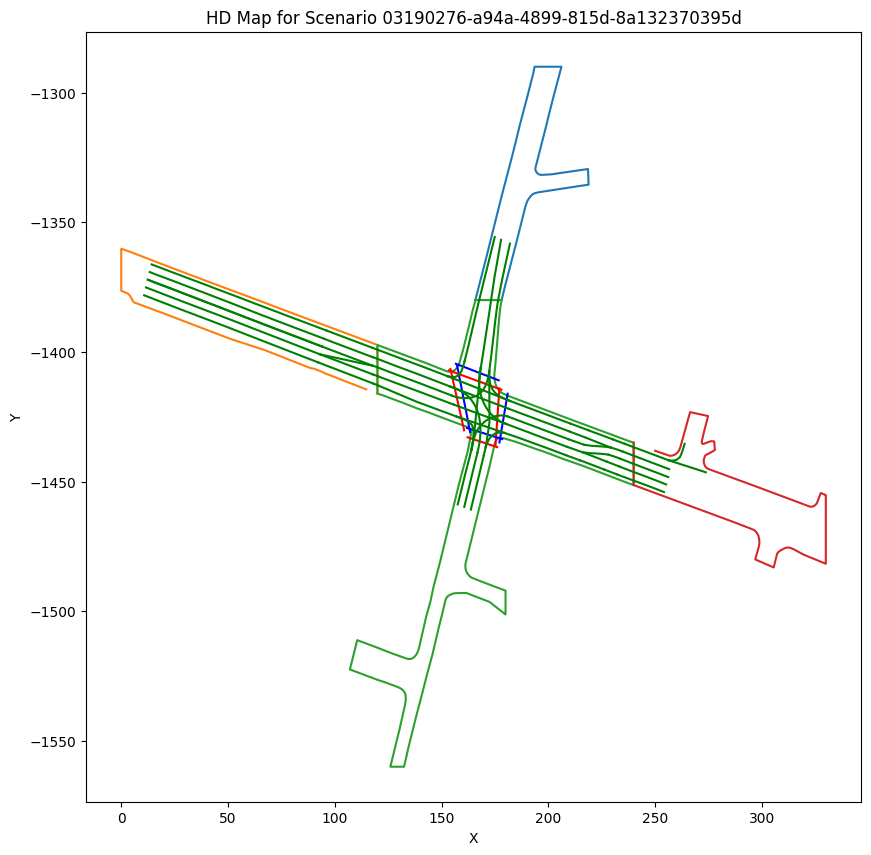

HD Map Image saved at: ./hd_maps/03190276-a94a-4899-815d-8a132370395d_hd_map.png
World Trajectory Shape: (90, 110, 7)
Focused Object Trajectory Shape: (110, 7)
Y Labels Shape: (40, 7)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

def preprocess_scenario(scenario_id:str, base_path:str, output_dir:str, max_objects:int=80, future_steps:int=10):
    """
    Preprocesses data for a given scenario. Creates HD map images, world trajectories, focused object trajectory, and Y labels.

    Args:
    - scenario_id: Unique identifier for the scenario.
    - base_path: The base directory where all scenario folders are stored.
    - output_dir: Directory where the output (images, processed data) will be saved.
    - max_objects: The maximum number of objects to keep per scenario (default 80).
    - future_steps: Number of future time steps to predict for the focused object (default 10).

    Returns:
    - hd_map_image_path: Path to the saved HD map image.
    - world_trajectory_array: NumPy array of shape (max_objects, 110, 5), containing world trajectory data.
    - focused_object_trajectory: NumPy array of shape (110, 5), containing the focused object's trajectory.
    - y_labels: NumPy array of shape (future_steps, 5), containing the future positions, velocities, and heading of the focused object.
    """
    # Define the paths to the JSON and parquet files based on scenario_id
    scenario_folder = os.path.join(base_path, scenario_id)
    map_json_path = os.path.join(scenario_folder, f'log_map_archive_{scenario_id}.json')
    parquet_path = os.path.join(scenario_folder, f'scenario_{scenario_id}.parquet')

    # 1. Create the HD Map Image
    def create_hd_map_image(map_json_path, output_dir, scenario_id):
        with open(map_json_path, 'r') as f:
            json_data = json.load(f)

        plt.figure(figsize=(10, 10))

        # Plot drivable areas
        for area_id, area_info in json_data['drivable_areas'].items():
            boundary = area_info['area_boundary']
            x = [point['x'] for point in boundary]
            y = [point['y'] for point in boundary]
            plt.plot(x, y, label=f'Area {area_id}')

        # Plot pedestrian crossings
        for crossing_id, crossing_info in json_data['pedestrian_crossings'].items():
            edge1 = crossing_info['edge1']
            edge2 = crossing_info['edge2']
            x1 = [point['x'] for point in edge1]
            y1 = [point['y'] for point in edge1]
            x2 = [point['x'] for point in edge2]
            y2 = [point['y'] for point in edge2]
            plt.plot(x1, y1, label=f'Pedestrian {crossing_id} edge1', color='blue')
            plt.plot(x2, y2, label=f'Pedestrian {crossing_id} edge2', color='red')

        # Plot lane segments
        for lane_id, lane_info in json_data['lane_segments'].items():
            centerline = lane_info['centerline']
            x = [point['x'] for point in centerline]
            y = [point['y'] for point in centerline]
            plt.plot(x, y, label=f'Lane {lane_id} centerline', color='green')

        # Save the HD map image
        #hd_map_image_path = os.path.join(output_dir, f"{scenario_id}_hd_map.png")
        plt.title(f"HD Map for Scenario {scenario_id}")
        plt.xlabel("X")
        plt.ylabel("Y")
        hd_map_image_path='./hd_maps/'+scenario_id+'_hd_map.png'
        plt.savefig(hd_map_image_path)
        plt.show()

        plt.close()

        return hd_map_image_path

    # 2. Extract World Trajectories
    def extract_world_trajectories(parquet_path:str, max_objects:int):
        df = pd.read_parquet(parquet_path)

        # Sort by track_id and timestep
        df = df.sort_values(by=['track_id', 'timestep'])

        # Extract the features of interest
        features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y','object_category','timestep']

        # Group by track_id
        grouped = df.groupby('track_id')

        # Create a list to hold object data
        objects = []

        # Loop through each object and extract trajectory data
        for track_id, object_group in grouped:
            if len(object_group) == 110:  # Ensure 110 time steps
                object_trajectory = object_group[features][0:110].to_numpy()  # Shape: (0:80, 5)
                objects.append(object_trajectory)

        # Stack the objects and pad/truncate to max_objects
        objects_array = np.stack(objects)
        num_objects = objects_array.shape[0]

        # Pad or truncate to max_objects
        if num_objects < max_objects:
            padded_objects_array = np.pad(objects_array, ((0, max_objects - num_objects), (0, 0), (0, 0)), mode='constant', constant_values=0)
        elif num_objects > max_objects:
            padded_objects_array = objects_array[:max_objects, :, :]
        else:
            padded_objects_array = objects_array

        return padded_objects_array

    # 3. Extract Focused Object Trajectory
    def extract_focused_object_trajectory(parquet_path:str):
        df = pd.read_parquet(parquet_path)

        # Identify the focal object based on `focal_track_id`
        focal_track_id = df['focal_track_id'].iloc[0]

        # Extract the trajectory for the focal object
        focused_object_df = df[df['track_id'] == focal_track_id]

        # Ensure there are exactly 110 time steps
        assert len(focused_object_df) == 110, "Focal object does not have 110 time steps"

        # Extract the 5 features of interest
        features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y','object_category','timestep']
        focused_object_trajectory = focused_object_df[features][0:110].values  # Shape: (0:80, 6)
        return focused_object_trajectory

    # 4. Generate Y Labels
    def generate_y_labels(focused_object_trajectory, future_steps):
        # Extract the last `future_steps` from the trajectory as the prediction target
        y_labels = focused_object_trajectory[-future_steps:, :]  # Shape: (future_steps, 5)
        return y_labels

    # Create the HD map image
    hd_map_image_path = create_hd_map_image(map_json_path, output_dir, scenario_id)

    # Extract the world trajectories
    world_trajectory_array = extract_world_trajectories(parquet_path, max_objects)

    # Extract the focused object trajectory
    focused_object_trajectory = extract_focused_object_trajectory(parquet_path)

    # Generate the Y labels
    y_labels = generate_y_labels(focused_object_trajectory, future_steps)

    return hd_map_image_path, world_trajectory_array, focused_object_trajectory, y_labels


# Example usage:
base_path = '/argotrain/train/'  # Base directory where all scenario folders are stored
scenario_id = '03190276-a94a-4899-815d-8a132370395d'  # Example scenario ID
output_dir = './output'  # Directory to store the processed output

hd_map_image_path, world_trajectory_array, focused_object_trajectory, y_labels = preprocess_scenario(
    scenario_id, base_path, output_dir, max_objects=90, future_steps=40
)

print(f"HD Map Image saved at: {hd_map_image_path}")
print(f"World Trajectory Shape: {world_trajectory_array.shape}")
print(f"Focused Object Trajectory Shape: {focused_object_trajectory.shape}")
print(f"Y Labels Shape: {y_labels.shape}")


In [ ]:
list_of_scenarios=os.listdir('/argotrain/train/')

In [ ]:
len(list_of_scenarios)

199908

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import io

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def create_hd_map_image_as_numpy(map_json_path:str, target_size:tuple)=(224, 224):
    """
    Create an HD map image from the given map JSON and return it as a resized NumPy array (RGB).

    Args:
    - map_json_path: Path to the map JSON file.
    - target_size: Tuple (width, height) to resize the image to. Default is (224, 224).

    Returns:
    - hd_map_image_np: NumPy array representing the resized HD map image (RGB).
    """
    with open(map_json_path, 'r') as f:
        json_data = json.load(f)

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot drivable areas
    for area_id, area_info in json_data['drivable_areas'].items():
        boundary = area_info['area_boundary']
        x = [point['x'] for point in boundary]
        y = [point['y'] for point in boundary]
        ax.plot(x, y)

    # Plot lane segments
    for lane_id, lane_info in json_data['lane_segments'].items():
        centerline = lane_info['centerline']
        x = [point['x'] for point in centerline]
        y = [point['y'] for point in centerline]
        ax.plot(x, y, color='green')

    # Convert plot to a NumPy array without saving it to disk
    canvas = FigureCanvas(fig)
    buf = io.BytesIO()
    canvas.print_png(buf)  # Save figure as PNG to the buffer
    buf.seek(0)

    # Convert buffer into a PIL image
    img = Image.open(buf)

    # If the image has an alpha channel (4 channels), convert it to RGB (3 channels)
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Resize the image to the target size
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)

    # Convert the resized PIL Image to a NumPy array
    hd_map_image_np = np.array(img_resized)

    # Close the buffer and the plot
    buf.close()
    plt.close(fig)

    return hd_map_image_np



In [ ]:
list_of_parquet_files = []
for scenario_id in list_of_scenarios:
  scenario_folder_path = os.path.join('/argotrain/train/', scenario_id)
  if os.path.isdir(scenario_folder_path):
    for file_name in os.listdir(scenario_folder_path):
      if file_name.endswith('.parquet'):
        list_of_parquet_files.append(os.path.join(scenario_folder_path, file_name))


In [ ]:
list_of_json_files = []
for scenario_id in list_of_scenarios:
  scenario_folder_path = os.path.join('/argotrain/train/', scenario_id)
  if os.path.isdir(scenario_folder_path):
    for file_name in os.listdir(scenario_folder_path):
      if file_name.endswith('.json'):
        list_of_json_files.append(os.path.join(scenario_folder_path, file_name))



In [ ]:
list_of_parquet_files[0:10]

['/argotrain/train/7b4a763a-6986-49cb-af1d-0d797c1cb575/scenario_7b4a763a-6986-49cb-af1d-0d797c1cb575.parquet',
 '/argotrain/train/6326630b-f9d7-455d-ae35-3a245b5b0be8/scenario_6326630b-f9d7-455d-ae35-3a245b5b0be8.parquet',
 '/argotrain/train/7b1ba740-780f-43f6-93cc-713e02fe1a5e/scenario_7b1ba740-780f-43f6-93cc-713e02fe1a5e.parquet',
 '/argotrain/train/dd2a1c6e-e342-42bc-a2f9-928f25f30ffd/scenario_dd2a1c6e-e342-42bc-a2f9-928f25f30ffd.parquet',
 '/argotrain/train/8aeb3737-17ee-462b-979c-ceb75d522ea7/scenario_8aeb3737-17ee-462b-979c-ceb75d522ea7.parquet',
 '/argotrain/train/3db415f0-9970-4cbe-8258-c8e0e6d3bbe3/scenario_3db415f0-9970-4cbe-8258-c8e0e6d3bbe3.parquet',
 '/argotrain/train/cf895ef4-62cb-47d7-b8d6-80ec9d040dba/scenario_cf895ef4-62cb-47d7-b8d6-80ec9d040dba.parquet',
 '/argotrain/train/15c52016-f88e-4092-ba02-855f3fdb525b/scenario_15c52016-f88e-4092-ba02-855f3fdb525b.parquet',
 '/argotrain/train/30fb1872-a75b-4f16-b2af-a614073c3ee6/scenario_30fb1872-a75b-4f16-b2af-a614073c3ee6.pa

In [ ]:
list_of_json_files[0:10]

['/argotrain/train/7b4a763a-6986-49cb-af1d-0d797c1cb575/log_map_archive_7b4a763a-6986-49cb-af1d-0d797c1cb575.json',
 '/argotrain/train/6326630b-f9d7-455d-ae35-3a245b5b0be8/log_map_archive_6326630b-f9d7-455d-ae35-3a245b5b0be8.json',
 '/argotrain/train/7b1ba740-780f-43f6-93cc-713e02fe1a5e/log_map_archive_7b1ba740-780f-43f6-93cc-713e02fe1a5e.json',
 '/argotrain/train/dd2a1c6e-e342-42bc-a2f9-928f25f30ffd/log_map_archive_dd2a1c6e-e342-42bc-a2f9-928f25f30ffd.json',
 '/argotrain/train/8aeb3737-17ee-462b-979c-ceb75d522ea7/log_map_archive_8aeb3737-17ee-462b-979c-ceb75d522ea7.json',
 '/argotrain/train/3db415f0-9970-4cbe-8258-c8e0e6d3bbe3/log_map_archive_3db415f0-9970-4cbe-8258-c8e0e6d3bbe3.json',
 '/argotrain/train/cf895ef4-62cb-47d7-b8d6-80ec9d040dba/log_map_archive_cf895ef4-62cb-47d7-b8d6-80ec9d040dba.json',
 '/argotrain/train/15c52016-f88e-4092-ba02-855f3fdb525b/log_map_archive_15c52016-f88e-4092-ba02-855f3fdb525b.json',
 '/argotrain/train/30fb1872-a75b-4f16-b2af-a614073c3ee6/log_map_archive_

In [ ]:
prequet_files=[]
for parquet_path in list_of_parquet_files[0:10]:
    prequet_files.append(extract_world_trajectories(parquet_path, max_objects=100))
prequet_files=np.array(prequet_files).shape

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
covered_time=80
future_time= 30
def extract_world_trajectories(parquet_path:str, max_objects:int=80, observed_timesteps:int=80):
    """
    Extract world trajectories for the observed timesteps.

    Args:
    - parquet_path: Path to the .parquet file.
    - max_objects: Maximum number of objects to extract.
    - observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
    - World trajectory array of shape (max_objects, observed_timesteps, 7).
    """
    df = pd.read_parquet(parquet_path)
    df = df.sort_values(by=['track_id', 'timestep'])
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']

    grouped = df.groupby('track_id')
    objects = [object_group[features].to_numpy()[:observed_timesteps]  # Only take the observed timesteps
               for _, object_group in grouped if len(object_group) >= observed_timesteps]

    objects_array = np.stack(objects)

    # Pad or truncate to max_objects
    return np.pad(objects_array, ((0, max_objects - len(objects)), (0, 0), (0, 0)), mode='constant')


def extract_focused_object_trajectory(parquet_path, observed_timesteps=80):
        """
        Extract the focused object's trajectory up to the observed timesteps.

        Args:
        - parquet_path: Path to the .parquet file.
        - observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

        Returns:
        - Focused object trajectory array of shape (observed_timesteps, 7).
        """
        df = pd.read_parquet(parquet_path)
        focal_track_id = df['focal_track_id'].iloc[0]
        focused_object_df = df[df['track_id'] == focal_track_id]

        features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']
        return focused_object_df[features].to_numpy()[:observed_timesteps]  # Only take the observed timesteps

def generate_y_labels(parquet_path, future_steps=30):
    """
    Generate Y labels for the future timesteps (t+1 to t+N).

    Args:
    - focused_object_trajectory: The full trajectory data for the focused object.
    - future_steps: Number of future timesteps to predict.

    Returns:
    - Y labels of shape (future_steps, 7).

    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']
    return focused_object_df[features].to_numpy()[-future_steps:, :]


observed_timesteps = 80  # Timesteps for input
future_steps = 30  # Timesteps for prediction

# Example usage:
world_trajectories_np=[]
for parquet_path in list_of_parquet_files[0:500]:
    world_trajectories_np.append(extract_world_trajectories(parquet_path, max_objects=80, observed_timesteps=80))
world_trajectories_np=np.array(world_trajectories_np)
print(world_trajectories_np.shape)


hd_maps_np=[]
for json_file in list_of_json_files[0:500]:
  hd_maps_np.append(create_hd_map_image_as_numpy(json_file))
hd_maps_np=np.array(hd_maps_np)
print(hd_maps_np.shape)





focal_object_trajectories=[]
for json_file in list_of_parquet_files[0:500]:
  focal_object_trajectories.append(extract_focused_object_trajectory(json_file, observed_timesteps=covered_time))
focal_object_trajectories=np.array(focal_object_trajectories)
print(focal_object_trajectories.shape)

# Generate Y labels for the future steps of the focused object trajectory
focal_object_trajectories_y_labels = []
for car in list_of_parquet_files[0:500]:
    focal_object_trajectories_y_labels.append(generate_y_labels(car, future_steps=future_time))
focal_object_trajectories_y_labels = np.array(focal_object_trajectories_y_labels)
print(f"Focused Object Y Labels Shape: {focal_object_trajectories_y_labels.shape}")



#extract_world_trajectories(parquet_path, max_objects)

In [ ]:
 import tensorflow as tf
from tensorflow.keras import backend as K

def min_ade(y_true, y_pred):
    """
    Calculate the Minimum Average Displacement Error (minADE) over all predicted trajectories.

    Args:
    - y_true: Ground truth future positions (batch_size, future_steps, 2) -> (position_x, position_y)
    - y_pred: Predicted future positions (batch_size, future_steps, 2)

    Returns:
    - minADE: Minimum average displacement error between the predicted and ground truth trajectories.
    """
    # Compute L2 distance (Euclidean distance) between y_true and y_pred at each timestep
    l2_distance = tf.sqrt(tf.reduce_sum(tf.square(y_true[:, :, :2] - y_pred[:, :, :2]), axis=-1))  # Shape: (batch_size, future_steps)

    # Compute the average displacement error over all timesteps
    ade = tf.reduce_mean(l2_distance, axis=-1)  # Shape: (batch_size,)

    # Take the mean across all examples in the batch
    return tf.reduce_mean(ade)  # Scalar


In [ ]:
def min_ade(y_true, y_pred):
    """
    Calculate the Minimum Average Displacement Error (minADE) over all predicted trajectories.

    Args:
    - y_true: Ground truth future positions (batch_size, future_steps, 7)
    - y_pred: Predicted future positions (batch_size, future_steps, 7)

    Returns:
    - minADE: Minimum average displacement error between the predicted and ground truth trajectories.
    """
    # Compute L2 distance (Euclidean distance) between y_true and y_pred at each timestep for position_x and position_y
    tf.print(y_pred)
    tf.print(y_true)
    l2_distance = tf.sqrt(tf.reduce_sum(tf.square(y_true[:, :, :2] - y_pred[:, :, :2]), axis=-1))  # Shape: (batch_size, future_steps)

    # Compute the average displacement error over all timesteps
    ade = tf.reduce_mean(l2_distance, axis=-1)  # Shape: (batch_size,)

    # Take the mean across all examples in the batch
    return tf.reduce_mean(ade)  # Scalar
def min_fde(y_true, y_pred):
    """
    Calculate the Minimum Final Displacement Error (minFDE) over all predicted trajectories.

    Args:
    - y_true: Ground truth future positions (batch_size, future_steps, 7)
    - y_pred: Predicted future positions (batch_size, future_steps, 7)

    Returns:
    - minFDE: Minimum final displacement error between the predicted and ground truth final positions.
    """
    # Compute L2 distance for the final position (last timestep) for position_x and position_y
    tf.print(y_pred)
    tf.print(y_true)
    l2_distance = tf.sqrt(tf.reduce_sum(tf.square(y_true[:, -1, :2] - y_pred[:, -1, :2]), axis=-1))  # Shape: (batch_size,)

    # Take the mean across all examples in the batch
    return tf.reduce_mean(l2_distance)  # Scalar

from tensorflow.keras import layers, models
import tensorflow as tf

def autoregressive_feature_fusion_decoder(hd_map_features, world_trajectory_features, focused_object_features, timesteps=30, output_dim=7):
    # Flatten and concatenate the inputs
    hd_map_flat = layers.Flatten()(hd_map_features)
    world_trajectory_flat = layers.Flatten()(world_trajectory_features)
    focused_object_flat = layers.Flatten()(focused_object_features)


    low_dim_hp_map = layers.Dense(64)(hd_map_flat)
    low_dim_world_trajectory = layers.Dense(64)(world_trajectory_flat)
    low_dim_focused_object = layers.Dense(64)(focused_object_flat)

    #fused_features = layers.Concatenate()([low_dim_hp_map, low_dim_world_trajectory, low_dim_focused_object])
    #fused_features = layers.Concatenate()([hd_map_flat, world_trajectory_flat, focused_object_flat])
    # Reshape the inputs to add an extra dimension for attention mechanism (batch_size, seq_len, feature_dim)
    low_dim_hp_map_reshaped = layers.Reshape((1, 64))(low_dim_hp_map)  # Assuming single time step, reshape as necessary
    low_dim_world_trajectory_reshaped = layers.Reshape((1, 64))(low_dim_world_trajectory)
    low_dim_focused_object_reshaped = layers.Reshape((1, 64))(low_dim_focused_object)
    fused_features = layers.MultiHeadAttention(num_heads=8, key_dim=64)(
        query=low_dim_hp_map_reshaped,
        key=low_dim_world_trajectory_reshaped,
        value=low_dim_focused_object_reshaped
    )





    # Repeat the fused features for each timestep
    squeezed_features = layers.Reshape((64,))(fused_features)  # Removing the sequence length dimension


    # Repeat the fused features for each timestep
    repeated_features = layers.RepeatVector(timesteps)(squeezed_features)
    # Use TimeDistributed to apply the Dense layers for each timestep with shared weights
    x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(repeated_features)
    output = layers.TimeDistributed(layers.Dense(output_dim))(x)  # Output for each timestep


    return output


def final_model():
    hd_map_input = layers.Input(shape=(224, 224, 3), name='hd_map_input')
    world_trajectory_input = layers.Input(shape=(80, 80, 7), name='world_trajectory_input')
    focused_object_input = layers.Input(shape=(80, 7), name='focused_trajectory_input')

    hd_map_features = hd_map_encoder()(hd_map_input)
    world_trajectory_features = world_trajectory_encoder()(world_trajectory_input)
    focused_object_features = focused_object_encoder()(focused_object_input)

    predictions = autoregressive_feature_fusion_decoder(hd_map_features, world_trajectory_features, focused_object_features, timesteps=30, output_dim=7)

    return models.Model(inputs=[hd_map_input, world_trajectory_input, focused_object_input], outputs=predictions)


In [ ]:
# Compile and build the model
model = final_model()  # Assuming you've defined your model
model.compile(optimizer='adam', loss='mse')  # Using minADE and minFDE as metrics
model.summary()



Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ world_trajectory_input    │ (None, 80, 80, 7)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hd_map_input (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ focused_trajectory_input  │ (None, 80, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_112            │ (None, 80, 80, 7)      │         31,765 │ world_trajectory_inpu… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_111            │ (None, 196, 384)       │      5,024,256 │ hd_map_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_113            │ (None, 80, 7)          │         31,765 │ focused_trajectory_in… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_80 (Flatten)      │ (None, 44800)          │              0 │ functional_112[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_79 (Flatten)      │ (None, 75264)          │              0 │ functional_111[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_81 (Flatten)      │ (None, 560)            │              0 │ functional_113[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_207 (Dense)         │ (None, 64)             │      2,867,264 │ flatten_80[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_206 (Dense)         │ (None, 64)             │      4,816,960 │ flatten_79[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_208 (Dense)         │ (None, 64)             │         35,904 │ flatten_81[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_92 (Reshape)      │ (None, 1, 64)          │              0 │ dense_207[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_91 (Reshape)      │ (None, 1, 64)          │              0 │ dense_206[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_93 (Reshape)      │ (None, 1, 64)          │              0 │ dense_208[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_116  │ (None, 1, 64)          │        132,672 │ reshape_92[0][0],      │
│ (MultiHeadAttention)      │                        │                │ reshape_91[0][0],      │
│                           │                        │                │ reshape_93[0][0]       │
├──────────────────────

 Total params: 12,949,809 (49.40 MB)

 Trainable params: 12,949,809 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and build the model
model = final_model()  # Assuming you've defined your model
model.compile(optimizer='adam', loss='mse')  # Using minADE and minFDE as metrics
model.summary()

# Train the model
history = model.fit(
    [hd_maps_np, world_trajectories_np, focal_object_trajectories],  # Inputs
    focal_object_trajectories_y_labels,  # Outputs (Y labels)
    epochs=100,  # Adjust as needed
    batch_size=6,  # Adjust batch size based on available memory
    validation_split=0.2  # Use 20% of data for validation
)

# Print the training results
print("Training completed.")


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ world_trajectory_input    │ (None, 80, 80, 7)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hd_map_input (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ focused_trajectory_input  │ (None, 80, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_54             │ (None, 80, 80, 7)      │         31,765 │ world_trajectory_inpu… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_53             │ (None, 196, 384)       │      5,024,256 │ hd_map_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_55             │ (None, 80, 7)          │         31,765 │ focused_trajectory_in… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_43 (Flatten)      │ (None, 44800)          │              0 │ functional_54[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_42 (Flatten)      │ (None, 75264)          │              0 │ functional_53[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_44 (Flatten)      │ (None, 560)            │              0 │ functional_55[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_173 (Dense)         │ (None, 64)             │      2,867,264 │ flatten_43[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_172 (Dense)         │ (None, 64)             │      4,816,960 │ flatten_42[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_174 (Dense)         │ (None, 64)             │         35,904 │ flatten_44[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_48 (Reshape)      │ (None, 1, 64)          │              0 │ dense_173[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_47 (Reshape)      │ (None, 1, 64)          │              0 │ dense_172[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_49 (Reshape)      │ (None, 1, 64)          │              0 │ dense_174[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_53   │ (None, 1, 64)          │        132,672 │ reshape_48[0][0],      │
│ (MultiHeadAttention)      │                        │                │ reshape_47[0][0],      │
│                           │                        │                │ reshape_49[0][0]       │
├──────────────────────

 Total params: 12,949,809 (49.40 MB)

 Trainable params: 12,949,809 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


67/67 ━━━━━━━━━━━━━━━━━━━━ 2765s 41s/step - loss: 2338465.5000 - val_loss: 854414.3750
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2693s 40s/step - loss: 878648.8750 - val_loss: 985304.9375
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2763s 41s/step - loss: 875743.4375 - val_loss: 949981.3750
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2794s 42s/step - loss: 957263.0000 - val_loss: 886375.7500
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2731s 41s/step - loss: 803248.9375 - val_loss: 851652.0625
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2729s 41s/step - loss: 860113.8750 - val_loss: 597118.4375
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2690s 40s/step - loss: 616852.6875 - val_loss: 550816.8125
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2689s 40s/step - loss: 562085.6875 - val_loss: 403987.0938
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2742s 41s/step - loss: 464430.4688 - val_loss: 332930.0625
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2802s 42s/step - loss: 386302.2188 - val_loss: 298043.9062
Epoch 11/100
67/67 ━━━━━━━━━━━

KeyboardInterrupt: 

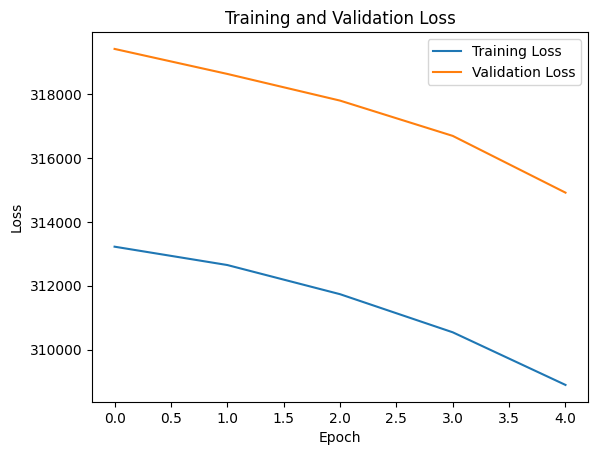

In [ ]:
# prompt: plot history

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## TRYING TO LOWER DIMENTIONS

In [ ]:
# Compile and build the model
model = final_model()  # Assuming you've defined your model
model.compile(optimizer='adam', loss='mse')  # Using minADE and minFDE as metrics
model.summary()



Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ world_trajectory_input    │ (None, 80, 80, 7)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hd_map_input (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ focused_trajectory_input  │ (None, 80, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_50             │ (None, 80, 80, 7)      │         31,765 │ world_trajectory_inpu… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_49             │ (None, 196, 384)       │      5,024,256 │ hd_map_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_51             │ (None, 80, 7)          │         31,765 │ focused_trajectory_in… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_40 (Flatten)      │ (None, 44800)          │              0 │ functional_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_39 (Flatten)      │ (None, 75264)          │              0 │ functional_49[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_41 (Flatten)      │ (None, 560)            │              0 │ functional_51[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_168 (Dense)         │ (None, 64)             │      2,867,264 │ flatten_40[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_167 (Dense)         │ (None, 64)             │      4,816,960 │ flatten_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_169 (Dense)         │ (None, 64)             │         35,904 │ flatten_41[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_43 (Reshape)      │ (None, 1, 64)          │              0 │ dense_168[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_42 (Reshape)      │ (None, 1, 64)          │              0 │ dense_167[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_44 (Reshape)      │ (None, 1, 64)          │              0 │ dense_169[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_49   │ (None, 1, 64)          │        132,672 │ reshape_43[0][0],      │
│ (MultiHeadAttention)      │                        │                │ reshape_42[0][0],      │
│                           │                        │                │ reshape_44[0][0]       │
├──────────────────────

 Total params: 12,949,809 (49.40 MB)

 Trainable params: 12,949,809 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

for i in range(10):
    print(focal_object_trajectories_y_labels[0][i])
    print(predictions[0][i])
    print('example', i)


    print(focal_object_trajectories_y_labels[1][i])
    print(predictions[1][i])
    print('example 2 ', i)

[ 1.47631344e+03 -1.15225541e+01  1.07625237e+00  6.74100362e-01
  1.19914749e+00  3.00000000e+00  8.00000000e+01]
[ 0.0277916   0.15833005 -0.11272052  0.00944901  0.05388178 -0.03981474
  0.2226526 ]
example 0
[ 1.07381853e+03 -1.03474540e+03 -2.50049946e-01  1.14431505e+00
 -2.46371254e-01  3.00000000e+00  8.00000000e+01]
[ 0.13144964  0.02762595 -0.00733693  0.44303048 -0.21528709 -0.1927617
  0.40598512]
example 2  0
[ 1.47637722e+03 -1.14047238e+01  1.06062452e+00  6.96680487e-01
  1.18853895e+00  3.00000000e+00  8.10000000e+01]
[ 0.0277916   0.15833005 -0.11272052  0.00944901  0.05388178 -0.03981474
  0.2226526 ]
example 1
[ 1.07393680e+03 -1.03477995e+03 -2.40314160e-01  1.15946091e+00
 -2.46461802e-01  3.00000000e+00  8.10000000e+01]
[ 0.13144964  0.02762595 -0.00733693  0.44303048 -0.21528709 -0.1927617
  0.40598512]
example 2  1
[ 1.47644229e+03 -1.12853997e+01  1.04583652e+00  7.17717922e-01
  1.17320764e+00  3.00000000e+00  8.20000000e+01]
[ 0.0277916   0.15833005 -0.11272

In [ ]:
focal_object_trajectories_y_labels[0][0]

array([ -321.22094358, -1036.20524349,    -1.87289   ,    -2.32545336,
          -7.55023379,     3.        ,    80.        ])

In [ ]:
predictions[0][0]

array([ -571.1655  , -1531.6342  ,   -23.254293,    34.807064,
         -12.918059,    25.016565,   171.8393  ], dtype=float32)

In [ ]:
predictions=model.predict([hd_maps_np, world_trajectories_np, focal_object_trajectories])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [ ]:


print(focal_object_trajectories_y_labels[0][1])
predictions[0][1]

[ -321.46977277 -1036.98111006    -1.87597       -2.35613841
    -7.57462358     3.            81.        ]


array([ -571.1655  , -1531.6342  ,   -23.254293,    34.807064,
         -12.918059,    25.016565,   171.8393  ], dtype=float32)

In [ ]:
for i in range(10):
  print(focal_object_trajectories_y_labels[1][i])
  print(predictions[1][i])

[ 927.95311165 2804.08975272   -2.81107383  -15.4999263    -5.32628818
    3.           80.        ]
[ 6.0724146e+02  2.6368875e+03 -3.3282707e+01 -6.9369917e+00
 -1.3046019e+00  1.6053644e+01  1.1606640e+02]
[ 926.40274496 2803.52988887   -2.81198451  -15.49125986   -5.30957376
    3.           81.        ]
[ 6.0724146e+02  2.6368875e+03 -3.3282707e+01 -6.9369917e+00
 -1.3046019e+00  1.6053644e+01  1.1606640e+02]
[ 924.85756943 2802.96526661   -2.81170519  -15.47531676   -5.30109909
    3.           82.        ]
[ 6.0724146e+02  2.6368875e+03 -3.3282707e+01 -6.9369917e+00
 -1.3046019e+00  1.6053644e+01  1.1606640e+02]
[ 923.31582572 2802.39979968   -2.81071869  -15.44846049   -5.30266199
    3.           83.        ]
[ 6.0724146e+02  2.6368875e+03 -3.3282707e+01 -6.9369917e+00
 -1.3046019e+00  1.6053644e+01  1.1606640e+02]
[ 921.77587147 2801.83403036   -2.80932795  -15.42158712   -5.30426591
    3.           84.        ]
[ 6.0724146e+02  2.6368875e+03 -3.3282707e+01 -6.9369917e+00
 -

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to resize a NumPy array (HD map image) to a specified size (224x224)
def resize_image(np_img, size=(224, 224)):
    img = Image.fromarray(np_img)  # Convert NumPy array to PIL Image
    img_resized = img.resize(size,  Image.Resampling.LANCZOS)  # Resize the image
    return np.array(img_resized)  # Convert resized PIL Image back to NumPy array


# Process the first 10 files, get both original and resized versions
hd_map_files_original = []  # To store original 1000x1000 images
hd_map_files_resized = []  # To store resized 224x224 images

for json_file in list_of_json_files[:10]:
    # Get the HD map as a NumPy array (original size)
    hd_map_np = create_hd_map_image_as_numpy(json_file)

    # Store original image
    hd_map_files_original.append(hd_map_np)

    # Resize the image to 224x224 and store
    hd_map_files_resized.append(resize_image(hd_map_np, size=(224, 224)))

# Convert to NumPy arrays
hd_map_files_original = np.array(hd_map_files_original)  # Shape: (10, 1000, 1000, 4)
hd_map_files_resized = np.array(hd_map_files_resized)  # Shape: (10, 224, 224, 4)

# Print the shapes to confirm
print(f"Original HD Map Shape: {hd_map_files_original.shape}")  # Expected: (10, 1000, 1000, 4)
print(f"Resized HD Map Shape: {hd_map_files_resized.shape}")  # Expected: (10, 224, 224, 4)


Original HD Map Shape: (10, 224, 224, 3)
Resized HD Map Shape: (10, 224, 224, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_original_and_resized(original_images, resized_images, num_samples=3):
    """
    Visualize the original and resized HD map images side by side.

    Args:
    - original_images: List or NumPy array of original images (1000x1000)
    - resized_images: List or NumPy array of resized images (224x224)
    - num_samples: Number of images to display for comparison
    """
    for i in range(num_samples):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Show the original 1000x1000 image
        axes[0].imshow(original_images[i])
        axes[0].set_title(f"Original HD Map ({original_images[i].shape[0]}x{original_images[i].shape[1]})")
        axes[0].axis('off')  # Turn off axis

        # Show the resized 224x224 image
        axes[1].imshow(resized_images[i])
        axes[1].set_title(f"Resized HD Map (224x224)")
        axes[1].axis('off')  # Turn off axis

        # Show the side-by-side plots
        plt.show()

# Example usage
visualize_original_and_resized(hd_map_files_original, hd_map_files_resized, num_samples=3)


In [ ]:
def extract_world_trajectories(parquet_path, max_objects=100, observed_timesteps=80):

    df = pd.read_parquet(parquet_path)
    df = df.sort_values(by=['track_id', 'timestep'])
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']

    grouped = df.groupby('track_id')
    objects = [object_group[features].to_numpy()[:observed_timesteps]
               for _, object_group in grouped if len(object_group) >= observed_timesteps]

    objects_array = np.stack(objects)

    # Pad or truncate to max_objects
    return np.pad(objects_array, ((0, max_objects - len(objects)), (0, 0), (0, 0)), mode='constant')


In [ ]:
focal_object_trajectories=[]
for json_file in list_of_parquet_files[0:10]:
  focal_object_trajectories.append(extract_focused_object_trajectory(json_file))
focal_object_trajectories=np.array(focal_object_trajectories)

In [ ]:
focal_object_trajectories.shape

(10, 110, 7)

In [ ]:
focal_object_trajectories_y_labels.shape

(10, 30, 7)

In [ ]:
list_of_parquet_files = os.listdir("/argotrain/train")

In [ ]:
len(list_of_parquet_files)

199908

In [ ]:
list_of_parquet_files_string=[]
for i in range(20):
  print(list_of_parquet_files[i])
  #list_of_parquet_files_string.append("/argotrain/train/"+list_of_parquet_files[i]+"/scenario_"+list_of_parquet_files[i]+".parquet")



093ea451-a3f9-470d-932c-b6e522ab09ec
57a77b70-2a70-47ad-a774-0f3339c1bbe2
53f809fa-7c12-4127-b86c-03c76e7b057a
3d5c9b7c-fa5f-4baa-9c8a-6bdd52dfa2b6
3ff49661-a152-41af-8109-4857645561c5
5c1d0408-2fcb-4ded-8e6b-16d230947827
bed15440-4806-4e3f-b438-edb33497c402
ad5fd509-47e9-4b64-973e-035aafeee871
62dc8319-3909-4a00-a597-3d3eab740c14
99a971e8-d59d-4e9f-9fda-3001cabaa36b
1c0933ad-a4a4-47da-ad0a-cf08cc67dcb9
66b1eeea-32a0-4c14-a8f0-cfe1edc92af4
e5ff7fea-1f19-4886-96a9-6d20bd0be500
53169c13-b827-4b51-bc17-d1c5cb51f5e0
9772165a-5cd2-4f2d-ba9e-c5f533b473e3
1118589e-3254-4cf2-bafa-ccafdddb676e
6948b2f4-f98b-4bbb-aae5-ccad39e03e7b
bc9c6230-c6bb-45b4-9b9e-c19ecf05db49
13b4a966-0b2c-4eec-bf88-f3dcd6b4fa68
779e8641-9e46-4589-bae6-433163e279c5


In [ ]:
#"/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet"
list_of_parquet_files_string=[]
for i in range(199908):
  list_of_parquet_files_string.append("/argotrain/train/"+list_of_parquet_files[i]+"/scenario_"+list_of_parquet_files[i]+".parquet")



In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Parameters
covered_time = 80  # Observed timesteps
future_time = 30   # Future timesteps
max_objects = 80   # Maximum number of objects

# 1. Extract World Trajectories
def extract_world_trajectories(parquet_path, max_objects=80, observed_timesteps=80):
    """
    Extract world trajectories for the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        max_objects: Maximum number of objects to extract.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        World trajectory array of shape (max_objects, observed_timesteps, 7).
    """
    df = pd.read_parquet(parquet_path)
    df = df.sort_values(by=['track_id', 'timestep'])
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']

    grouped = df.groupby('track_id')
    objects = [object_group[features].to_numpy()[:observed_timesteps]
               for _, object_group in grouped if len(object_group) >= observed_timesteps]

    objects_array = np.stack(objects)

    # Pad or truncate to max_objects
    return np.pad(objects_array, ((0, max_objects - len(objects)), (0, 0), (0, 0)), mode='constant')


# 2. Extract Focused Object Trajectory
def extract_focused_object_trajectory(parquet_path, observed_timesteps=80):
    """
    Extract the focused object's trajectory up to the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        Focused object trajectory array of shape (observed_timesteps, 7).
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']
    return focused_object_df[features].to_numpy()[:observed_timesteps]


# 3. Generate Multi-Modal Logistic Regression Y-Labels
def generate_multi_modal_y_labels(parquet_path, future_steps=30, num_modalities=2, bins=20):
    """
    Generate multi-modal Y labels for the future timesteps (t+1 to t+N).

    Args:
        parquet_path: Path to the .parquet file.
        future_steps: Number of future timesteps to predict.
        num_modalities: Number of output modalities (e.g., angular distances, distance percentages).
        bins: Number of bins to discretize continuous values.

    Returns:
        Y labels of shape (future_steps, num_modalities, bins): Probabilities for each trajectory class.
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    # Extract required features for predictions
    positions = focused_object_df[['position_x', 'position_y']].to_numpy()
    headings = focused_object_df['heading'].to_numpy()

    # Calculate modalities for future timesteps
    future_positions = positions[-future_steps:]

    future_headings = headings[-future_steps:]

    current_position = positions[-future_steps - 1]
    current_heading = headings[-future_steps - 1]

    # Modality 1: Angular distance (difference in headings)
    angular_distances = (future_headings - current_heading)

    # Modality 2: Distance percentage (distance change as a percentage)
    distance_changes = np.linalg.norm(future_positions - current_position, axis=1) / np.linalg.norm(current_position)

    # Discretize modalities into bins
    angular_classes = np.digitize(angular_distances, bins=np.linspace(-np.pi, np.pi, bins))
    distance_classes = np.digitize(distance_changes, bins=np.linspace(0, 1, bins))

    # One-hot encode classes for each modality
    num_classes = bins
    angular_one_hot = np.eye(num_classes)[angular_classes-1]
    distance_one_hot = np.eye(num_classes)[distance_classes]

    # Stack modalities into final Y-labels
    y_labels = np.stack([angular_one_hot, distance_one_hot], axis=1)  # Shape: (T, M, C)
    return y_labels


# 4. Discretize Trajectories (for Multi-Modal Classification)
def discretize_trajectories(future_positions, bins=20):
    """
    Discretize continuous trajectory data into discrete bins for classification.

    Args:
        future_positions: Array of future positions (t+1 to t+N).
        bins: Number of bins to discretize continuous values.

    Returns:
        Discretized trajectory classes (integer labels).
    """
    x_bins = np.digitize(future_positions[:, 0], bins=np.linspace(future_positions[:, 0].min(), future_positions[:, 0].max(), bins))
    y_bins = np.digitize(future_positions[:, 1], bins=np.linspace(future_positions[:, 1].min(), future_positions[:, 1].max(), bins))
    heading_bins = np.digitize(future_positions[:, 2], bins=np.linspace(future_positions[:, 2].min(), future_positions[:, 2].max(), bins))

    # Combine bins into a single trajectory class
    trajectory_classes = x_bins * bins**2 + y_bins * bins + heading_bins
    return trajectory_classes


# Dataset Class
class ArgoverseMultiModalDataset(Dataset):
    def __init__(self, world_trajectories, focused_trajectories, labels):
        self.world_trajectories = torch.tensor(world_trajectories, dtype=torch.float32)
        self.focused_trajectories = torch.tensor(focused_trajectories, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.world_trajectories[idx], self.focused_trajectories[idx], self.labels[idx]


# Preprocess and Create Dataset
list_of_parquet_files_main = list_of_parquet_files_string#["/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet",
                         #"/argotrain/train/0000b6ab-e100-4f6b-aee8-b520b57c0530/scenario_0000b6ab-e100-4f6b-aee8-b520b57c0530.parquet",
                         #"/argotrain/train/0001b567-b7ac-4a91-b4fe-6132e4b81884/scenario_0001b567-b7ac-4a91-b4fe-6132e4b81884.parquet",
                         #"/argotrain/train/0001f576-0552-49c9-9ce2-8c47411a088e/scenario_0001f576-0552-49c9-9ce2-8c47411a088e.parquet"]  # Update with actual paths
world_trajectories_np = []
focused_trajectories_np = []
labels_np = []

for parquet_path in list_of_parquet_files_main:
    world_traj = extract_world_trajectories(parquet_path, max_objects, covered_time)
    focused_traj = extract_focused_object_trajectory(parquet_path, covered_time)
    y_labels = generate_multi_modal_y_labels(parquet_path, future_time,bins=200)

    world_trajectories_np.append(world_traj)
    focused_trajectories_np.append(focused_traj)
    labels_np.append(y_labels)

world_trajectories_np = np.array(world_trajectories_np)
focused_trajectories_np = np.array(focused_trajectories_np)
labels_np = np.array(labels_np)

dataset = ArgoverseMultiModalDataset(world_trajectories_np, focused_trajectories_np, labels_np)
dataloader = DataLoader(dataset, batch_size=120, shuffle=True)
temp_batch_y=[]
# Example Batch
for batch_world, batch_focused, batch_labels in dataloader:
    print("Batch World Trajectories Shape:", batch_world.shape)
    print("Batch Focused Trajectories Shape:", batch_focused.shape)
    print("Batch Labels Shape:", batch_labels.shape)
    temp_batch_y=batch_labels
    break


## PYTORCH MDOEL, CAN RUN

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Parameters
covered_time = 80     # Observed timesteps
future_time = 30      # Future timesteps
max_objects = 80      # Maximum number of objects
bins = 120            # Number of bins for discretization

# Pre-determined Global Bin Ranges (Set based on prior analysis done above)
x_range_min = 0.0
x_range_max = 41.7139
y_range_min = -5.5628
y_range_max = 6.2710
heading_range_min = -0.7035
heading_range_max = 0.7346

# DISCLAIMER: CHATGPT 4.0 HAS ASSISTED IN CREATING THE BINNING METHODS.
def reconstruct_position_from_labels(x_prev, y_prev, heading_prev, labels_t, bins):
    """
    Reconstructs the position at time t given the previous position and labels.

    Args:
        x_prev (float): Previous x position (at time t-31).
        y_prev (float): Previous y position (at time t-31).
        heading_prev (float): Previous heading (at time t-31).
        labels_t (np.ndarray): One-hot encoded labels at time t-30, shape (3, bins).
        bins (int): Number of bins used in discretization.

    Returns:
        x_curr (float): Reconstructed x position at time t-30.
        y_curr (float): Reconstructed y position at time t-30.
        heading_curr (float): Reconstructed heading at time t-30.
    """
    # Step 1: Convert one-hot labels to class indices
    x_class = np.argmax(labels_t[0])
    y_class = np.argmax(labels_t[1])
    heading_class = np.argmax(labels_t[2])
    # SAME AS ABOVE, CAN REMOVE, REDUNTANT
    x_range_min = 0.0
    x_range_max = 41.7139
    y_range_min = -5.5628
    y_range_max = 6.2710
    heading_range_min = -0.7035
    heading_range_max = 0.7346


    x_bin_edges = np.linspace(x_range_min, x_range_max, bins + 1)
    y_bin_edges = np.linspace(y_range_min, y_range_max, bins + 1)
    heading_bin_edges = np.linspace(heading_range_min, heading_range_max, bins + 1)
    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    y_bin_centers = (y_bin_edges[:-1] + y_bin_edges[1:]) / 2
    heading_bin_centers = (heading_bin_edges[:-1] + heading_bin_edges[1:]) / 2
    delta_x_agent = x_bin_centers[x_class]
    delta_y_agent = y_bin_centers[y_class]
    delta_heading = heading_bin_centers[heading_class]
    cos_theta = np.cos(heading_prev)
    sin_theta = np.sin(heading_prev)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])
    delta_pos_agent = np.array([delta_x_agent, delta_y_agent])
    delta_pos_world = rotation_matrix @ delta_pos_agent

    x_curr = x_prev + delta_pos_world[0]
    y_curr = y_prev + delta_pos_world[1]
    heading_curr = heading_prev + delta_heading
    heading_curr = (heading_curr + np.pi) % (2 * np.pi) - np.pi

    return x_curr, y_curr, heading_curr

# 1. Extract World Trajectories
def extract_world_trajectories(parquet_path:str, max_objects:int=80, observed_timesteps:int=80):
    """
    Extract world trajectories for the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        max_objects: Maximum number of objects to extract.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        World trajectory array of shape (max_objects, observed_timesteps, 7).
    """
    df = pd.read_parquet(parquet_path)
    df = df.sort_values(by=['track_id', 'timestep'])
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']

    grouped = df.groupby('track_id')
    objects = [object_group[features].to_numpy()[:observed_timesteps]
               for _, object_group in grouped if len(object_group) >= observed_timesteps]

    # Pad or truncate to max_objects, though padding is not ideal, this is to be changed later on FIX_ME
    objects_array = np.zeros((max_objects, observed_timesteps, len(features)))
    num_objects = min(len(objects), max_objects)
    objects_array[:num_objects] = objects[:num_objects]

    return objects_array

# 2. Extract Focused Object Trajectory
def extract_focused_object_trajectory(parquet_path, observed_timesteps=80):
    """
    Extract the focused object's trajectory up to the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        Focused object trajectory array of shape (observed_timesteps, 7).
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]
    # Feautures to use
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category', 'timestep']
    return focused_object_df[features].to_numpy()[:observed_timesteps]

# 3. Transform Positions to Agent Frame
def transform_to_agent_frame(positions, current_position, current_heading):
    """
    Transform positions to the agent's frame of reference.

    Args:
        positions: Array of positions to transform.
        current_position: The agent's current position.
        current_heading: The agent's current heading.

    Returns:
        Transformed positions in the agent's frame.
    """

    positions_translated = positions - current_position


    cos_theta = np.cos(-current_heading)
    sin_theta = np.sin(-current_heading)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])

    positions_rotated = positions_translated @ rotation_matrix.T

    return positions_rotated

# 4. Generate Multi-Modal Y-Labels with Absolute Changes
def generate_multi_modal_y_labels(parquet_path, future_steps=30):
    """
    Generate multi-modal Y labels for the future timesteps (t+1 to t+N),
    using absolute changes in position and heading in the agent's frame.

    Args:
        parquet_path: Path to the .parquet file.
        future_steps: Number of future timesteps to predict.

    Returns:
        Y labels of shape (future_steps, 3): [x_change, y_change, heading_change]
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    # Extract required features for predictions
    positions = focused_object_df[['position_x', 'position_y']].to_numpy()
    headings = focused_object_df['heading'].to_numpy()

    # Ensure we have enough timesteps
    if len(positions) < future_steps + 1:
        raise ValueError("Not enough timesteps for future steps.")

    # Get current position and heading
    current_position = positions[-future_steps - 1]
    current_heading = headings[-future_steps - 1]

    # Get future positions and headings
    future_positions = positions[-future_steps:]
    future_headings = headings[-future_steps:]


    future_positions_agent_frame = transform_to_agent_frame(future_positions, current_position, current_heading)


    delta_headings = future_headings - current_heading

    delta_headings = (delta_headings + np.pi) % (2 * np.pi) - np.pi


    y_labels = np.hstack([
        future_positions_agent_frame,
        delta_headings.reshape(-1, 1)
    ])

    return y_labels

# 5. Discretize Changes into Fixed-Width Bins
def discretize_changes_fixed(changes, bins, range_min, range_max):
    """
    Discretize continuous changes into discrete bins using fixed-width bins.

        changes: Array of continuous changes.
        bins: Number of bins to discretize into.
        range_min: Minimum value of the range.
        range_max: Maximum value of the range.

    Returns:
        classes: Array of integer class labels.
        bin_edges: The edges of the bins used.
    """
    bin_edges = np.linspace(range_min, range_max, bins + 1)
    classes = np.digitize(changes, bin_edges, right=False) - 1
    # Clip classes to valid range
    classes = np.clip(classes, 0, bins - 1)
    return classes, bin_edges

# 6. Generate Discrete Y-Labels with Global Bin Ranges
def generate_discrete_y_labels_global(y_labels, bins):
    """
    Generate discrete labels from continuous absolute changes using global bin ranges.


        y_labels: Continuous labels of shape (future_steps, 3).
        bins: Number of bins to discretize into.

    Returns:
        y_discrete_labels: One-hot encoded labels of shape (future_steps, 3, bins).
    """
    x_changes = y_labels[:, 0]
    y_changes = y_labels[:, 1]
    heading_changes = y_labels[:, 2]

    # Use the pre-determined bin ranges
    global x_range_min, x_range_max
    global y_range_min, y_range_max
    global heading_range_min, heading_range_max

    # Clip changes to be within the bin ranges
    x_changes_clipped = np.clip(x_changes, x_range_min, x_range_max)
    y_changes_clipped = np.clip(y_changes, y_range_min, y_range_max)
    heading_changes_clipped = np.clip(heading_changes, heading_range_min, heading_range_max)

    # Discretize the changes
    x_classes, x_bin_edges = discretize_changes_fixed(x_changes_clipped, bins, x_range_min, x_range_max)
    y_classes, y_bin_edges = discretize_changes_fixed(y_changes_clipped, bins, y_range_min, y_range_max)
    heading_classes, heading_bin_edges = discretize_changes_fixed(heading_changes_clipped, bins, heading_range_min, heading_range_max)

    # One-hot encode the classes
    x_one_hot = np.eye(bins)[x_classes]
    y_one_hot = np.eye(bins)[y_classes]
    heading_one_hot = np.eye(bins)[heading_classes]

    # Stack the one-hot encoded classes
    y_discrete_labels = np.stack([x_one_hot, y_one_hot, heading_one_hot], axis=1)

    return y_discrete_labels


class ArgoverseMultiModalDataset(Dataset):
    def __init__(self, world_trajectories, focused_trajectories, labels):
        self.world_trajectories = torch.tensor(world_trajectories, dtype=torch.float32)
        self.focused_trajectories = torch.tensor(focused_trajectories, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.world_trajectories[idx], self.focused_trajectories[idx], self.labels[idx]


list_of_parquet_files = list_of_parquet_files_main[0:300]

world_trajectories_np = []
focused_trajectories_np = []
labels_np = []

for parquet_path in list_of_parquet_files:
    try:
        # Extract trajectories
        world_traj = extract_world_trajectories(parquet_path, max_objects, covered_time)
        focused_traj = extract_focused_object_trajectory(parquet_path, covered_time)

        # Generate continuous labels
        y_labels_continuous = generate_multi_modal_y_labels(parquet_path, future_time)

        # Generate discrete labels using the global bin ranges
        y_labels_discrete = generate_discrete_y_labels_global(
            y_labels_continuous, bins
        )

        # Append data
        world_trajectories_np.append(world_traj)
        focused_trajectories_np.append(focused_traj)
        labels_np.append(y_labels_discrete)

    except Exception as e:
        print(f"Error processing file {parquet_path}: {e}")

# Convert lists to numpy arrays
world_trajectories_np = np.array(world_trajectories_np)
focused_trajectories_np = np.array(focused_trajectories_np)
labels_np = np.array(labels_np)

# Create Dataset and DataLoader
dataset = ArgoverseMultiModalDataset(world_trajectories_np, focused_trajectories_np, labels_np)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example Batch
for batch_world, batch_focused, batch_labels in dataloader:
    print("Batch World Trajectories Shape:", batch_world.shape)
    print("Batch Focused Trajectories Shape:", batch_focused.shape)
    print("Batch Labels Shape:", batch_labels.shape)
    # Print sample labels
    print("Sample Labels Shape:", batch_labels[0].shape)
    #print("Sample Labels:", batch_labels[0])
    temp_batch_y=batch_labels
    break


## DONT RUN, THE RESULTS ARE AN ANALYSIS FOR BINS IMPLEMENTAION

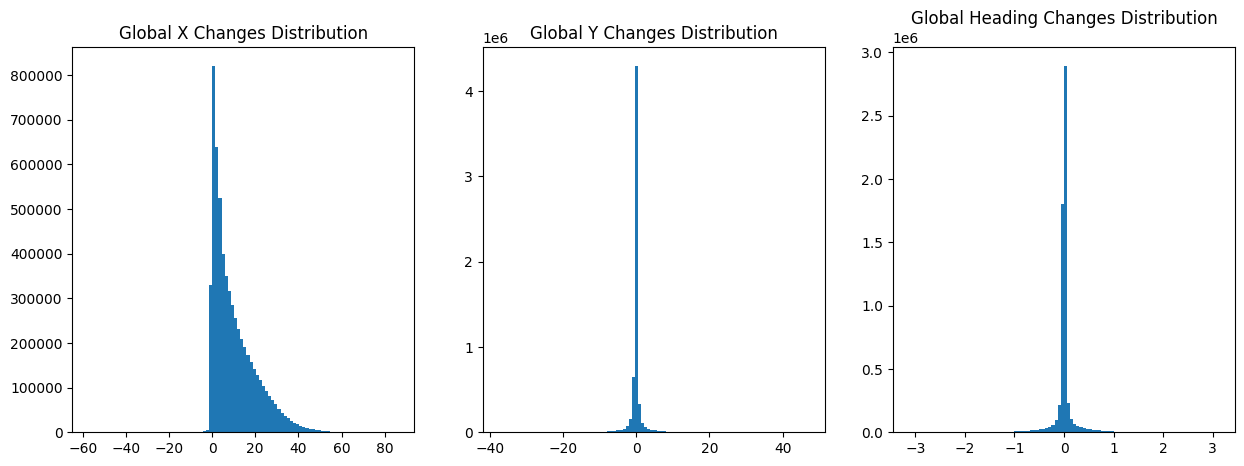

X Changes - min: -57.5793, max: 86.5215, mean: 10.1197, std: 10.0379
Y Changes - min: -37.7315, max: 47.2216, mean: -0.0121, std: 1.5879
Heading Changes - min: -3.1391, max: 3.1334, mean: 0.0029, std: 0.1865

X Changes Percentiles:
0th percentile: -57.5793
1th percentile: -0.0706
5th percentile: 0.0275
10th percentile: 0.4626
25th percentile: 2.2282
50th percentile: 6.9353
75th percentile: 15.3985
90th percentile: 24.7522
95th percentile: 30.4441
99th percentile: 41.7139
100th percentile: 86.5215

Y Changes Percentiles:
0th percentile: -37.7315
1th percentile: -5.5628
5th percentile: -1.5597
10th percentile: -0.7286
25th percentile: -0.1832
50th percentile: -0.0082
75th percentile: 0.1073
90th percentile: 0.5877
95th percentile: 1.5514
99th percentile: 6.2710
100th percentile: 47.2216

Heading Changes Percentiles:
0th percentile: -3.1391
1th percentile: -0.7035
5th percentile: -0.1936
10th percentile: -0.0676
25th percentile: -0.0138
50th percentile: -0.0000
75th percentile: 0.0135
90t

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


future_time = 30

# 1. Transform Positions to Agent Frame
def transform_to_agent_frame(positions, current_position, current_heading):
    """
    Transform positions to the agent's frame of reference.

    Args:
        positions: Array of positions to transform.
        current_position: The agent's current position.
        current_heading: The agent's current heading.

    Returns:
        Transformed positions in the agent's frame.
    """
    # Translate positions to the agent's current position
    positions_translated = positions - current_position

    # Rotate positions to align with the agent's heading
    cos_theta = np.cos(-current_heading)
    sin_theta = np.sin(-current_heading)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])

    positions_rotated = positions_translated @ rotation_matrix.T

    return positions_rotated

# 2. Generate Multi-Modal Y-Labels with Absolute Changes
def generate_multi_modal_y_labels(parquet_path, future_steps=30):
    """
    Generate multi-modal Y labels for the future timesteps (t+1 to t+N),
    using absolute changes in position and heading in the agent's frame.

    Args:
        parquet_path: Path to the .parquet file.
        future_steps: Number of future timesteps to predict.

    Returns:
        Y labels of shape (future_steps, 3): [x_change, y_change, heading_change]
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    # Extract required features for predictions
    positions = focused_object_df[['position_x', 'position_y']].to_numpy()
    headings = focused_object_df['heading'].to_numpy()

    # Ensure we have enough timesteps
    if len(positions) < future_steps + 1:
        raise ValueError("Not enough timesteps for future steps.")

    # Get current position and heading
    current_position = positions[-future_steps - 1]
    current_heading = headings[-future_steps - 1]

    # Get future positions and headings
    future_positions = positions[-future_steps:]
    future_headings = headings[-future_steps:]

    # Transform future positions to agent frame
    future_positions_agent_frame = transform_to_agent_frame(future_positions, current_position, current_heading)

    # Compute headings relative to current heading
    delta_headings = future_headings - current_heading
    # Normalize delta_headings to be within [-pi, pi]
    delta_headings = (delta_headings + np.pi) % (2 * np.pi) - np.pi

    # Combine positions and heading changes
    y_labels = np.hstack([
        future_positions_agent_frame,
        delta_headings.reshape(-1, 1)
    ])  # Shape: (future_steps, 3)

    return y_labels

# 3. Collect Global Changes Across All Files
def collect_global_changes(list_of_parquet_files):
    """
    Collects changes in x, y, and heading across all files.

    Args:
        list_of_parquet_files: List of file paths to process.

    Returns:
        global_x_changes: Numpy array of all x changes.
        global_y_changes: Numpy array of all y changes.
        global_heading_changes: Numpy array of all heading changes.
    """
    global_x_changes = []
    global_y_changes = []
    global_heading_changes = []

    for parquet_path in list_of_parquet_files:
        try:
            # Generate labels
            y_labels_continuous = generate_multi_modal_y_labels(parquet_path, future_time)
            x_changes = y_labels_continuous[:, 0]
            y_changes = y_labels_continuous[:, 1]
            heading_changes = y_labels_continuous[:, 2]

            # Append to global lists
            global_x_changes.extend(x_changes)
            global_y_changes.extend(y_changes)
            global_heading_changes.extend(heading_changes)
        except Exception as e:
            print(f"Error processing file {parquet_path}: {e}")

    # Convert lists to numpy arrays
    global_x_changes = np.array(global_x_changes)
    global_y_changes = np.array(global_y_changes)
    global_heading_changes = np.array(global_heading_changes)

    return global_x_changes, global_y_changes, global_heading_changes

# 4. Analyze and Plot Global Distributions
def analyze_global_distributions(global_x_changes, global_y_changes, global_heading_changes):
    """
    Analyzes and plots the distributions of changes.

    Args:
        global_x_changes: Numpy array of all x changes.
        global_y_changes: Numpy array of all y changes.
        global_heading_changes: Numpy array of all heading changes.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(global_x_changes, bins=100)
    plt.title('Global X Changes Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(global_y_changes, bins=100)
    plt.title('Global Y Changes Distribution')

    plt.subplot(1, 3, 3)
    plt.hist(global_heading_changes, bins=100)
    plt.title('Global Heading Changes Distribution')

    plt.show()

    # Print summary statistics
    print("X Changes - min: {:.4f}, max: {:.4f}, mean: {:.4f}, std: {:.4f}".format(
        global_x_changes.min(), global_x_changes.max(), global_x_changes.mean(), global_x_changes.std()))
    print("Y Changes - min: {:.4f}, max: {:.4f}, mean: {:.4f}, std: {:.4f}".format(
        global_y_changes.min(), global_y_changes.max(), global_y_changes.mean(), global_y_changes.std()))
    print("Heading Changes - min: {:.4f}, max: {:.4f}, mean: {:.4f}, std: {:.4f}".format(
        global_heading_changes.min(), global_heading_changes.max(), global_heading_changes.mean(), global_heading_changes.std()))

    # Print percentiles
    percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
    print("\nX Changes Percentiles:")
    for percentile in percentiles:
        print("{}th percentile: {:.4f}".format(percentile, np.percentile(global_x_changes, percentile)))

    print("\nY Changes Percentiles:")
    for percentile in percentiles:
        print("{}th percentile: {:.4f}".format(percentile, np.percentile(global_y_changes, percentile)))

    print("\nHeading Changes Percentiles:")
    for percentile in percentiles:
        print("{}th percentile: {:.4f}".format(percentile, np.percentile(global_heading_changes, percentile)))



# Step 1: Collect global changes
global_x_changes, global_y_changes, global_heading_changes = collect_global_changes(list_of_parquet_files_string)

# Step 2: Analyze global distributions
analyze_global_distributions(global_x_changes, global_y_changes, global_heading_changes)


## Path reconstruction implementaion

actual_positions_full [[ 575.6344448  1862.47395878]
 [ 575.65646413 1861.21186482]
 [ 575.67455324 1859.96374249]
 [ 575.69179749 1858.71167083]
 [ 575.7078641  1857.42805144]
 [ 575.7180879  1856.13448381]
 [ 575.72481624 1854.8325244 ]
 [ 575.72632995 1853.51919873]
 [ 575.72145177 1852.22421102]
 [ 575.71049271 1850.9402728 ]
 [ 575.69473494 1849.66983136]
 [ 575.67608072 1848.39287564]
 [ 575.65911338 1847.11046053]
 [ 575.64597203 1845.8369375 ]
 [ 575.63708835 1844.5548781 ]
 [ 575.6321511  1843.26692071]
 [ 575.62386107 1841.98556846]
 [ 575.60851934 1840.71590954]
 [ 575.58776847 1839.45765031]
 [ 575.56191903 1838.19315867]
 [ 575.52524733 1836.93818076]
 [ 575.48284099 1835.64087444]
 [ 575.43396923 1834.27278333]
 [ 575.37884249 1832.90197984]
 [ 575.32320655 1831.56012337]
 [ 575.26569031 1830.2920925 ]
 [ 575.2089241  1829.13798156]
 [ 575.1568667  1828.09604459]
 [ 575.11210379 1827.17806052]
 [ 575.07793156 1826.39422634]
 [ 575.05790731 1825.75435739]]
positions_recons

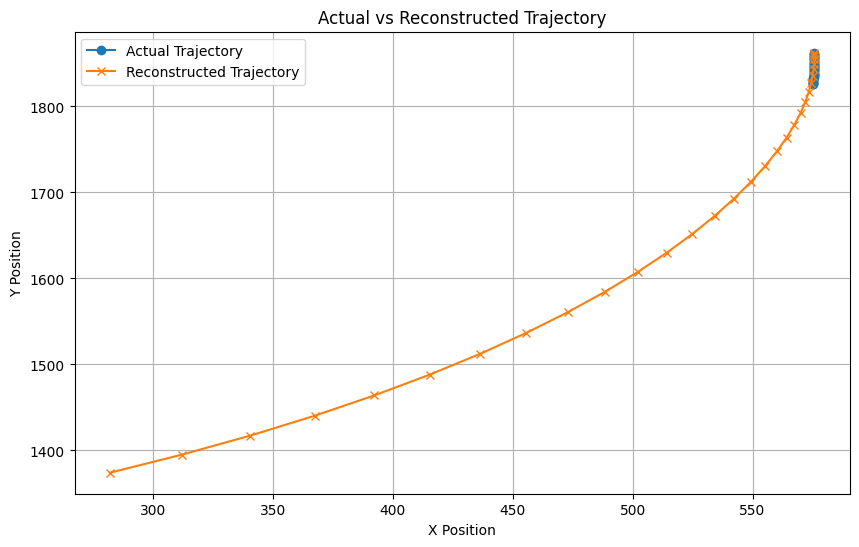

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


x_range_min = 0.0
x_range_max = 41.7139
y_range_min = -5.5628
y_range_max = 6.2710
heading_range_min = -0.7035
heading_range_max = 0.7346
#DISCLAIMER: CHATGPT ASSISTED IN THIS WORK
def generate_multi_modal_y_labels(parquet_path:str, future_steps:int=30):
    """
    Generate multi-modal Y labels for the future timesteps (t+1 to t+N),
    using absolute changes in position and heading in the agent's frame.

    Returns:
        y_labels: Continuous labels of shape (future_steps, 3).
        current_position: The agent's current position.
        current_heading: The agent's current heading.
        positions: The actual future positions in world coordinates.
        headings: The actual future headings.
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    # Extract required features for predictions
    positions = focused_object_df[['position_x', 'position_y']].to_numpy()
    headings = focused_object_df['heading'].to_numpy()

    # Ensure we have enough timesteps
    if len(positions) < future_steps + 1:
        raise ValueError("Not enough timesteps for future steps.")

    # Get current position and heading
    current_position = positions[-future_steps - 1]
    current_heading = headings[-future_steps - 1]

    # Get future positions and headings
    future_positions = positions[-future_steps:]
    future_headings = headings[-future_steps:]

    # Transform future positions to agent frame
    future_positions_agent_frame = transform_to_agent_frame(
        future_positions, current_position, current_heading)

    # Compute headings relative to current heading
    delta_headings = future_headings - current_heading
    # Normalize delta_headings to be within [-pi, pi]
    delta_headings = (delta_headings + np.pi) % (2 * np.pi) - np.pi

    # Combine positions and heading changes
    y_labels = np.hstack([
        future_positions_agent_frame,
        delta_headings.reshape(-1, 1)
    ])  # Shape: (future_steps, 3)

    return y_labels, current_position, current_heading, future_positions, future_headings

def test_reconstruction(parquet_path, future_steps=30):
    # Step 1: Generate continuous labels and get actual positions and headings
    y_labels_continuous, current_position, current_heading, actual_positions, actual_headings = generate_multi_modal_y_labels(parquet_path, future_steps)

    # Step 2: Discretize labels
    y_labels_discrete = generate_discrete_y_labels_global(y_labels_continuous, bins)

    # Step 3: Reconstruct positions from labels
    x_prev, y_prev = current_position
    heading_prev = current_heading

    positions_reconstructed = [current_position]
    headings_reconstructed = [current_heading]

    for t in range(future_steps):
        # Get the labels at time t
        labels_t = y_labels_discrete[t]  # Shape: (3, bins)
        # Reconstruct position at time t
        x_curr, y_curr, heading_curr = reconstruct_position_from_labels(
            x_prev, y_prev, heading_prev, labels_t, bins)
        # Append reconstructed position and heading
        positions_reconstructed.append([x_curr, y_curr])
        headings_reconstructed.append(heading_curr)
        # Update previous position and heading
        x_prev, y_prev = x_curr, y_curr
        heading_prev = heading_curr

    positions_reconstructed = np.array(positions_reconstructed)
    headings_reconstructed = np.array(headings_reconstructed)

    # Actual positions (including current position)
    actual_positions_full = np.vstack([current_position, actual_positions])

    position_differences = positions_reconstructed - actual_positions_full
    heading_differences = headings_reconstructed - np.hstack([current_heading, actual_headings])
    print('actual_positions_full', actual_positions_full)
    print('positions_reconstructed', positions_reconstructed)
    heading_differences = (heading_differences + np.pi) % (2 * np.pi) - np.pi

    print("Position differences (x, y):")
    print(position_differences)
    print("Heading differences:")
    print(heading_differences)

    # Optionally, calculate the mean absolute error
    position_error = np.mean(np.linalg.norm(position_differences, axis=1))
    heading_error = np.mean(np.abs(heading_differences))

    print(f"\nMean Position Error: {position_error:.4f} meters")
    print(f"Mean Heading Error: {heading_error:.4f} radians")

    return positions_reconstructed, headings_reconstructed, actual_positions_full, position_differences, heading_differences


def reconstruct_position_from_labels(x_prev, y_prev, heading_prev, labels_t, bins):
    # Step 1: Convert one-hot labels to class indices
    x_class = np.argmax(labels_t[0])
    y_class = np.argmax(labels_t[1])
    heading_class = np.argmax(labels_t[2])


    x_bin_edges = np.linspace(x_range_min, x_range_max, bins + 1)
    y_bin_edges = np.linspace(y_range_min, y_range_max, bins + 1)
    heading_bin_edges = np.linspace(heading_range_min, heading_range_max, bins + 1)

    # Compute bin centers
    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    y_bin_centers = (y_bin_edges[:-1] + y_bin_edges[1:]) / 2
    heading_bin_centers = (heading_bin_edges[:-1] + heading_bin_edges[1:]) / 2

    # Get delta values from class indices
    delta_x_agent = x_bin_centers[x_class]
    delta_y_agent = y_bin_centers[y_class]
    delta_heading = heading_bin_centers[heading_class]

    # Step 2: Transform delta_x and delta_y from agent frame to world frame
    cos_theta = np.cos(heading_prev)
    sin_theta = np.sin(heading_prev)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])

    delta_pos_agent = np.array([delta_x_agent, delta_y_agent])
    delta_pos_world = rotation_matrix @ delta_pos_agent

    # Step 3: Compute new position
    x_curr = x_prev + delta_pos_world[0]
    y_curr = y_prev + delta_pos_world[1]

    # Step 4: Compute new heading
    heading_curr = heading_prev + delta_heading

    heading_curr = (heading_curr + np.pi) % (2 * np.pi) - np.pi

    return x_curr, y_curr, heading_curr



parquet_path = list_of_parquet_files[20]
positions_reconstructed, headings_reconstructed, actual_positions_full, position_differences, heading_differences = test_reconstruction(parquet_path)


plt.figure(figsize=(10, 6))
plt.plot(actual_positions_full[:, 0], actual_positions_full[:, 1], label='Actual Trajectory', marker='o')
plt.plot(positions_reconstructed[:, 0], positions_reconstructed[:, 1], label='Reconstructed Trajectory', marker='x')
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Actual vs Reconstructed Trajectory')
plt.grid(True)
plt.show()


In [ ]:
len(global_heading_changes)/30

199908.0

In [ ]:
len(list_of_parquet_files_main)

400

## RUN

In [ ]:

list_of_parquet_files = os.listdir("/argotrain/train")
#"/argotrain/train/0000b0f9-99f9-4a1f-a231-5be9e4c523f7/scenario_0000b0f9-99f9-4a1f-a231-5be9e4c523f7.parquet"
list_of_parquet_files_string=[]
for i in range(199908):
  list_of_parquet_files_string.append("/argotrain/train/"+list_of_parquet_files[i]+"/scenario_"+list_of_parquet_files[i]+".parquet")



## CURRENT- *PYTORCH MODEL*

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader
#DISCLAIMER: CHATGPT ASSISTED IN THIS WORK
# Parameters
covered_time = 80      # Observed timesteps
future_time = 30       # Future timesteps
max_objects = 80       # Maximum number of objects per scenario
bins = 120              # Number of bins for discretization
batch_size = 16        # Batch size for training
num_epochs = 100        # Number of training epochs
learning_rate = 1e-4   # Learning rate for optimizer

x_range_min = 0.0
x_range_max = 41.7139
y_range_min = -5.5628
y_range_max = 6.2710
heading_range_min = -0.7035
heading_range_max = 0.7346


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Extract World Trajectories
def extract_world_trajectories(parquet_path, max_objects=80, observed_timesteps=80):
    """
    Extract world trajectories for the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        max_objects: Maximum number of objects to extract.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        World trajectory array of shape (max_objects, observed_timesteps, feature_dim).
    """
    df = pd.read_parquet(parquet_path)
    df = df.sort_values(by=['track_id', 'timestep'])
    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category']

    grouped = df.groupby('track_id')
    objects = [object_group[features].to_numpy()[:observed_timesteps]
               for _, object_group in grouped if len(object_group) >= observed_timesteps]


    # Pad or truncate to max_objects
    num_objects = min(len(objects), max_objects)
    objects_array = np.zeros((max_objects, observed_timesteps, len(features)))
    objects_array[:num_objects] = objects[:num_objects]
    #print("objects_array: ",objects_array.shape)
    #print("extract_world_trajectories: ",objects_array)

    return objects_array

# 2. Extract Focused Object Trajectory
def extract_focused_object_trajectory(parquet_path, observed_timesteps=80):
    """
    Extract the focused object's trajectory up to the observed timesteps.

    Args:
        parquet_path: Path to the .parquet file.
        observed_timesteps: The number of timesteps to include as input (i.e., the history up to t).

    Returns:
        Focused object trajectory array of shape (observed_timesteps, feature_dim).
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    features = ['position_x', 'position_y', 'heading', 'velocity_x', 'velocity_y', 'object_category']
    focused_object_df=focused_object_df[features].to_numpy()[:observed_timesteps]
    #print("focused_object_df: ",focused_object_df.shape)

    # Pad or truncate to max_objects
    #num_objects = min(len(objects), max_objects
    #print("focused_object_df: ",focused_object_df.shape)
    #print("focused_object_df: ",focused_object_df[:1])
    return focused_object_df

# 3. Transform Positions to Agent Frame
def transform_to_agent_frame(positions, current_position, current_heading):
    """
    Transform positions to the agent's frame of reference.

    Args:
        positions: Array of positions to transform.
        current_position: The agent's current position.
        current_heading: The agent's current heading.

    Returns:
        Transformed positions in the agent's frame.
    """
    # Translate positions to the agent's current position
    positions_translated = positions - current_position

    # Rotate positions to align with the agent's heading
    cos_theta = np.cos(-current_heading)
    sin_theta = np.sin(-current_heading)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                [sin_theta, cos_theta]])

    positions_rotated = positions_translated @ rotation_matrix.T

    return positions_rotated

# 4. Generate Multi-Modal Y-Labels with Absolute Changes
def generate_multi_modal_y_labels(parquet_path, future_steps=30):
    """
    Generate multi-modal Y labels for the future timesteps (t+1 to t+N),
    using absolute changes in position and heading in the agent's frame.

    Args:
        parquet_path: Path to the .parquet file.
        future_steps: Number of future timesteps to predict.

    Returns:
        y_labels: Continuous labels of shape (future_steps, 3).
        current_position: The agent's current position.
        current_heading: The agent's current heading.
        future_positions: The actual future positions in world coordinates.
        future_headings: The actual future headings.
    """
    df = pd.read_parquet(parquet_path)
    focal_track_id = df['focal_track_id'].iloc[0]
    focused_object_df = df[df['track_id'] == focal_track_id]

    # Extract required features for predictions
    positions = focused_object_df[['position_x', 'position_y']].to_numpy()
    #print("positions: ",positions)
    headings = focused_object_df['heading'].to_numpy()

    # Ensure we have enough timesteps
    if len(positions) < future_steps + 1:
        raise ValueError("Not enough timesteps for future steps.")

    # Get current position and heading
    current_position = positions[-future_steps - 1]
    current_heading = headings[-future_steps - 1]

    # Get future positions and headings
    future_positions = positions[-future_steps:]
    future_headings = headings[-future_steps:]

    # Transform future positions to agent frame
    future_positions_agent_frame = transform_to_agent_frame(
        future_positions, current_position, current_heading)

    # Compute headings relative to current heading
    delta_headings = future_headings - current_heading
    # Normalize delta_headings to be within [-pi, pi]
    delta_headings = (delta_headings + np.pi) % (2 * np.pi) - np.pi

    # Combine positions and heading changes
    y_labels = np.hstack([
        future_positions_agent_frame,
        delta_headings.reshape(-1, 1)
    ])  # Shape: (future_steps, 3)

    return y_labels, current_position, current_heading, future_positions, future_headings

# 5. Discretize Changes into Fixed-Width Bins
def discretize_changes_fixed(changes, bins, range_min, range_max):
    """
    Discretize continuous changes into discrete bins using fixed-width bins.

    Args:
        changes: Array of continuous changes.
        bins: Number of bins to discretize into.
        range_min: Minimum value of the range.
        range_max: Maximum value of the range.

    Returns:
        classes: Array of integer class labels.
        bin_edges: The edges of the bins used.
    """
    bin_edges = np.linspace(range_min, range_max, bins + 1)
    classes = np.digitize(changes, bin_edges, right=False) - 1
    # Clip classes to valid range
    classes = np.clip(classes, 0, bins - 1)
    return classes, bin_edges

# 6. Generate Discrete Y-Labels with Global Bin Ranges
def generate_discrete_y_labels_global(y_labels, bins):
    """
    Generate discrete labels from continuous absolute changes using global bin ranges.

    Args:
        y_labels: Continuous labels of shape (future_steps, 3).
        bins: Number of bins to discretize into.

    Returns:
        y_discrete_labels: Array of class indices of shape (future_steps, 3).
    """
    x_changes = y_labels[:, 0]
    y_changes = y_labels[:, 1]
    heading_changes = y_labels[:, 2]

    # Clip changes to be within the bin ranges
    x_changes_clipped = np.clip(x_changes, x_range_min, x_range_max)
    y_changes_clipped = np.clip(y_changes, y_range_min, y_range_max)
    heading_changes_clipped = np.clip(heading_changes, heading_range_min, heading_range_max)

    # Discretize the changes
    x_classes, _ = discretize_changes_fixed(x_changes_clipped, bins, x_range_min, x_range_max)
    y_classes, _ = discretize_changes_fixed(y_changes_clipped, bins, y_range_min, y_range_max)
    heading_classes, _ = discretize_changes_fixed(heading_changes_clipped, bins, heading_range_min, heading_range_max)

    # Stack the class indices
    y_discrete_labels = np.stack([x_classes, y_classes, heading_classes], axis=1)  # Shape: (future_steps, 3)

    return y_discrete_labels

# 7. Dataset Class
class ArgoverseDataset(Dataset):
    def __init__(self, parquet_files):
        self.parquet_files = parquet_files
        self.data = []
        self.prepare_data()

    def prepare_data(self):
        for parquet_path in self.parquet_files:
            try:
                # Extract trajectories
                world_traj = extract_world_trajectories(parquet_path, max_objects, covered_time)
                focused_traj = extract_focused_object_trajectory(parquet_path, covered_time)

                # Generate continuous labels
                y_labels_continuous, current_position, current_heading, future_positions, future_headings = generate_multi_modal_y_labels(parquet_path, future_time)

                # Generate discrete labels using the global bin ranges
                y_labels_discrete = generate_discrete_y_labels_global(
                    y_labels_continuous, bins
                )

                # Append data
                self.data.append({
                    'world_traj': world_traj,
                    'focused_traj': focused_traj,
                    'labels_continuous': y_labels_continuous,
                    'labels_discrete': y_labels_discrete,
                    'current_position': current_position,
                    'current_heading': current_heading
                })

            except Exception as e:
                print(f"Error processing file {parquet_path}: {e}")

    def __len__(self):
        return len(self.parquet_files)

    def __getitem__(self, idx):
        sample = self.data[idx]
        world_traj = torch.tensor(sample['world_traj'], dtype=torch.float32)
        focused_traj = torch.tensor(sample['focused_traj'], dtype=torch.float32)
        labels_discrete = torch.tensor(sample['labels_discrete'], dtype=torch.long)  # Changed to long for CrossEntropyLoss
        return world_traj, focused_traj, labels_discrete

class ArgoverseDataset(Dataset):
    def __init__(self,  parquet_files: List[str]):
      self.parquet_files = parquet_files

    def __len__(self):
        return len(self.parquet_files)

    def __getitem__(self, idx):
        parquet_path = self.parquet_files[idx]
        try:
            # Extract trajectories
            world_traj = extract_world_trajectories(parquet_path, max_objects, covered_time)
            focused_traj = extract_focused_object_trajectory(parquet_path, covered_time)

            # Generate continuous labels
            y_labels_continuous, current_position, current_heading, future_positions, future_headings = \
                generate_multi_modal_y_labels(parquet_path, future_time)

            # Generate discrete labels using the global bin ranges
            y_labels_discrete = generate_discrete_y_labels_global(y_labels_continuous, bins)

            # Convert data to tensors
            world_traj = torch.tensor(world_traj, dtype=torch.float32)
            focused_traj = torch.tensor(focused_traj, dtype=torch.float32)
            labels_discrete = torch.tensor(y_labels_discrete, dtype=torch.long)

            return world_traj, focused_traj, labels_discrete

        except Exception as e:
            print(f"Error processing file {parquet_path}: {e}")
            return None

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=10000):  # Increase maxlen
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)  # Shape: (1, maxlen, emb_size)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x):
        # x: (batch_size, seq_len, emb_size)
        seq_len = x.size(1)
        if seq_len > self.pos_embedding.size(1):
            raise ValueError(f"Input sequence length {seq_len} exceeds maximum length of positional encoding {self.pos_embedding.size(1)}")

        # Add positional encoding to input
        x = x + self.pos_embedding[:, :seq_len, :]
        return self.dropout(x)



# 9. Transformer Model with Separate Heads for X, Y, Heading
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size,
                 nhead, src_feature_size, tgt_feature_size, dim_feedforward=512,
                 dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.emb_size = emb_size
        #print("src_feature_size:", src_feature_size)
        #print("tgt_feature_size:", tgt_feature_size)
        #print("emb_size",emb_size)
        self.src_tok_emb = nn.Linear(src_feature_size, emb_size)
        self.tgt_tok_emb = nn.Linear(tgt_feature_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=True)  # Set batch_first=True to suppress warning
        # Separate generators for X, Y, and Heading
        self.generator_x = nn.Linear(emb_size, bins)
        self.generator_y = nn.Linear(emb_size, bins)
        self.generator_heading = nn.Linear(emb_size, bins)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None,
            src_padding_mask=None, tgt_padding_mask=None):
        # src: (batch_size, num_objects * observed_timesteps, src_feature_size)
        # tgt: (batch_size, tgt_seq_len, tgt_feature_size)
        tgt = tgt.float()  # Convert tgt to float
        # Embed source and target
        #print("type of src: ",src.dtype)
        #print("type of tgt: ", tgt.dtype)
        src = (src - src.mean()) / (src.std() + 1e-6)
        tgt = (tgt - tgt.mean()) / (tgt.std() + 1e-6)

        src_emb = self.src_tok_emb(src)  # (batch_size, seq_len, emb_size)
        tgt_emb = self.tgt_tok_emb(tgt)  # (batch_size, tgt_seq_len, emb_size)


        # Apply positional encoding
        src_emb = self.positional_encoding(src_emb)
        tgt_emb = self.positional_encoding(tgt_emb)

        # Transformer forward pass
        memory = self.transformer.encoder(src_emb, src_mask, src_padding_mask)
        output = self.transformer.decoder(tgt_emb, memory, tgt_mask, tgt_padding_mask)

        # Separate predictions for X, Y, and Heading
        out_x = self.generator_x(output)          # (batch_size, tgt_seq_len, bins)
        out_y = self.generator_y(output)          # (batch_size, tgt_seq_len, bins)
        out_heading = self.generator_heading(output)  # (batch_size, tgt_seq_len, bins)

        return out_x, out_y, out_heading


# 10. Helper Functions for Masking
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def train_epoch(model, optimizer, dataloader, loss_fn):
    model.train()
    total_loss = 0
    global_batch_count = 0
    for src_world, src_focused, tgt in dataloader:
        #print("train_epoch: src_world",src_world.shape)
        #print("train_epoch: src_focused",src_focused.shape)
        #print("train_epoch: tgt",tgt.shape)
        src_world = src_world.to(device)            # (batch_size, max_objects, observed_timesteps, world_feature_dim)
        src_focused = src_focused.to(device)        # (batch_size, observed_timesteps, focused_feature_dim)

        tgt = tgt.to(device)                        # (batch_size, future_time, 3)

        # Combine world and focused features
        # Reshape world trajectory into (batch_size, seq_len, world_feature_dim)
        #src_world_seq = src_world.view(batch_size, max_objects * covered_time, -1)
        #src_world_seq = src_world.view(batch_size, max_objects * covered_time, 6)
        # Reshape world trajectory into (batch_size, seq_len, world_feature_dim)
        src_world_seq = src_world.view(batch_size, max_objects * covered_time, src_world.size(-1))  # Use the last dimension dynamically



        # Repeat focused trajectory across all objects
        src_focused_seq = src_focused.unsqueeze(1).repeat(1, max_objects, 1, 1)
        src_focused_seq = src_focused_seq.view(batch_size, max_objects * covered_time, -1)
        #print("train_epoch: src_world_seq: ",src_world_seq.shape)
        #print("train_epoch: src_focused_seq: ",src_focused_seq.shape)

        # Concatenate world and focused features
        src_seq = torch.cat([src_world_seq, src_focused_seq], dim=2)  # (batch_size, seq_len, src_feature_size)

        # Verify src_seq shape
        #print(f"train_epoch: src_seq shape: {src_seq.shape}")

        # Prepare target sequences (shifted for teacher forcing)
        tgt_input = tgt[:, :-1, :]  # (batch_size, future_time - 1, 3)
        tgt_output = tgt[:, 1:, :]  # (batch_size, future_time - 1, 3)

        # Generate masks
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        # Forward pass
        optimizer.zero_grad()
        output_x, output_y, output_heading = model(src_seq, tgt_input, tgt_mask=tgt_mask)

        # Reshape outputs and targets for loss computation
        output_x = output_x.view(-1, bins)
        output_y = output_y.view(-1, bins)
        output_heading = output_heading.view(-1, bins)
        tgt_output_x = tgt_output[:, :, 0].contiguous().view(-1)
        tgt_output_y = tgt_output[:, :, 1].contiguous().view(-1)
        tgt_output_heading = tgt_output[:, :, 2].contiguous().view(-1)

        # Compute loss for each component
        loss_x = loss_fn(output_x, tgt_output_x)
        loss_y = loss_fn(output_y, tgt_output_y)
        loss_heading = loss_fn(output_heading, tgt_output_heading)
        loss = loss_x + loss_y + loss_heading
        if global_batch_count%1000==0:
            print("batch count",global_batch_count)
            print("batch loss", loss.item())
        global_batch_count+=1
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


# 12. Inference Function (Optional)
def greedy_decode(model, src, max_len, start_symbol):
    """
    Greedy decoding for inference.

    Args:
        model: Trained Transformer model.
        src: Source sequence (batch_size, src_seq_len, src_feature_dim).
        max_len: Maximum length of the target sequence to generate.
        start_symbol: Token to start the decoding.

    Returns:
        Generated sequence (batch_size, max_len, 3).
    """
    model.eval()
    src = src.to(device)

    # Encode source
    with torch.no_grad():
        memory = model.transformer.encoder(model.positional_encoding(model.src_tok_emb(src)))

    # Initialize target with start symbol
    ys = torch.zeros((src.size(0), 1, 3)).to(device)  # (batch_size, 1, 3)
    for i in range(max_len):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
        out_x, out_y, out_heading = model.transformer.decoder(
            model.positional_encoding(model.tgt_tok_emb(ys)), memory, tgt_mask=tgt_mask
        )
        out_x = model.generator_x(out_x)
        out_y = model.generator_y(out_y)
        out_heading = model.generator_heading(out_heading)

        # Get the latest predictions
        latest_x = out_x[:, -1, :]  # (batch_size, bins)
        latest_y = out_y[:, -1, :]  # (batch_size, bins)
        latest_heading = out_heading[:, -1, :]  # (batch_size, bins)

        # Choose the class with highest probability
        _, pred_x = torch.max(latest_x, dim=1)
        _, pred_y = torch.max(latest_y, dim=1)
        _, pred_heading = torch.max(latest_heading, dim=1)

        # Convert class indices to one-hot
        pred_x_one_hot = F.one_hot(pred_x, num_classes=bins).float()
        pred_y_one_hot = F.one_hot(pred_y, num_classes=bins).float()
        pred_heading_one_hot = F.one_hot(pred_heading, num_classes=bins).float()

        # Stack the predictions
        pred = torch.stack([pred_x_one_hot, pred_y_one_hot, pred_heading_one_hot], dim=2)  # (batch_size, 1, 3 * bins)

        # Append to target sequence
        ys = torch.cat([ys, pred], dim=1)

    return ys

# 13. Main Execution
if __name__ == "__main__":
    # List of .parquet file paths (Update with your actual file paths)
    parquet_files = list_of_parquet_files_string[0:320*620] #320*620
    # Create Dataset and DataLoader
    dataset = ArgoverseDataset(parquet_files)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define model parameters
    num_encoder_layers = 1
    num_decoder_layers = 1
    emb_size = 256
    nhead = 4
    src_feature_size = 76800 # max_objects * covered_time * 6 + covered_time * 6  # world_feature_dim * num_objects * observed_timesteps + focused_feature_dim * observed_timesteps
    tgt_feature_size = 3  # For x, y, heading classes
    src_feature_size = 12  # Number of features per timestep


    # Initialize model, loss function, and optimizer
    model = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size, nhead,
    src_feature_size, tgt_feature_size).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate/4)
        # Initialize the variable to track the best loss
    best_loss = float('inf')  # Start with infinity as the worst possible loss
    model_save_path = "best_model.pth"  # File path to save the model

    # Training loop
    for epoch in range(num_epochs):
        loss = train_epoch(model, optimizer, dataloader, loss_fn)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
        if loss < best_loss:
            best_loss = loss  # Update the best loss
            # Save the model's state_dict and optimizer's state_dict
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': loss
            }, model_save_path)
            print(f"Model saved with loss: {loss:.4f}")

    print("Training completed.")

batch count 0
batch loss 14.86777114868164
batch count 1000
batch loss 8.589120864868164
batch count 2000
batch loss 7.686376571655273
batch count 3000
batch loss 6.368773460388184
batch count 4000
batch loss 7.127032279968262
batch count 5000
batch loss 5.967325210571289
batch count 6000
batch loss 6.420708179473877
batch count 7000
batch loss 6.792972564697266
batch count 8000
batch loss 7.042896270751953
batch count 9000
batch loss 6.511423587799072
batch count 10000
batch loss 5.894780158996582
batch count 11000
batch loss 5.734317779541016
batch count 12000
batch loss 6.464262008666992
Epoch 1, Loss: 7.0134
Model saved with loss: 7.0134
batch count 0
batch loss 5.2813496589660645
batch count 1000
batch loss 4.832752227783203
batch count 2000
batch loss 6.933274269104004
batch count 3000
batch loss 5.601258277893066
batch count 4000
batch loss 5.2022705078125
batch count 5000
batch loss 4.623016357421875
batch count 6000
batch loss 5.035003662109375
batch count 7000
batch loss 6.01

In [ ]:
def train_epoch(model, optimizer, dataloader, loss_fn):
    model.train()
    total_loss = 0
    batch_count=0
    for src_world, src_focused, tgt in dataloader:
        #print("train_epoch: src_world",src_world.shape)
        #print("train_epoch: src_focused",src_focused.shape)
        #print("train_epoch: tgt",tgt.shape)
        src_world = src_world.to(device)            # (batch_size, max_objects, observed_timesteps, world_feature_dim)
        src_focused = src_focused.to(device)        # (batch_size, observed_timesteps, focused_feature_dim)

        tgt = tgt.to(device)                        # (batch_size, future_time, 3)

        # Combine world and focused features
        # Reshape world trajectory into (batch_size, seq_len, world_feature_dim)
        #src_world_seq = src_world.view(batch_size, max_objects * covered_time, -1)
        #src_world_seq = src_world.view(batch_size, max_objects * covered_time, 6)
        # Reshape world trajectory into (batch_size, seq_len, world_feature_dim)
        src_world_seq = src_world.view(batch_size, max_objects * covered_time, src_world.size(-1))


        # Repeat focused trajectory across all objects
        src_focused_seq = src_focused.unsqueeze(1).repeat(1, max_objects, 1, 1)
        src_focused_seq = src_focused_seq.view(batch_size, max_objects * covered_time, -1)
        #print("train_epoch: src_world_seq: ",src_world_seq.shape)
        #print("train_epoch: src_focused_seq: ",src_focused_seq.shape)

        # Concatenate world and focused features
        src_seq = torch.cat([src_world_seq, src_focused_seq], dim=2)  # (batch_size, seq_len, src_feature_size)

        # Verify src_seq shape
        #print(f"train_epoch: src_seq shape: {src_seq.shape}")

        # Prepare target sequences (shifted for teacher forcing)
        tgt_input = tgt[:, :-1, :]  # (batch_size, future_time - 1, 3)
        tgt_output = tgt[:, 1:, :]  # (batch_size, future_time - 1, 3)

        # Generate masks
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        # Forward pass
        optimizer.zero_grad()
        output_x, output_y, output_heading = model(src_seq, tgt_input, tgt_mask=tgt_mask)

        # Reshape outputs and targets for loss computation
        output_x = output_x.view(-1, bins)
        output_y = output_y.view(-1, bins)
        output_heading = output_heading.view(-1, bins)
        tgt_output_x = tgt_output[:, :, 0].contiguous().view(-1)
        tgt_output_y = tgt_output[:, :, 1].contiguous().view(-1)
        tgt_output_heading = tgt_output[:, :, 2].contiguous().view(-1)

        # Compute loss for each component
        loss_x = loss_fn(output_x, tgt_output_x)
        loss_y = loss_fn(output_y, tgt_output_y)
        loss_heading = loss_fn(output_heading, tgt_output_heading)
        loss = loss_x + loss_y + loss_heading
        #print("batch loss", loss.item())
        if batch_count%10000==0:
            print("batch count",batch_count)
            print("batch loss", loss.item())
        batch_count+=1
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# 13. Main Execution
if __name__ == "__main__":
    # List of .parquet file paths (Update with your actual file paths)
    parquet_files = list_of_parquet_files_string[0:320*620] #320*620
    # Create Dataset and DataLoader
    dataset = ArgoverseDataset(parquet_files)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define model parameters
    num_encoder_layers = 1
    num_decoder_layers = 1
    emb_size = 256
    nhead = 4
    src_feature_size = 76800 # max_objects * covered_time * 6 + covered_time * 6  # world_feature_dim * num_objects * observed_timesteps + focused_feature_dim * observed_timesteps
    tgt_feature_size = 3  # For x, y, heading classes
    src_feature_size = 12  # Number of features per timestep


    # Initialize model, loss function, and optimizer
    #model = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size, nhead,
    #src_feature_size, tgt_feature_size).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # Initialize the variable to track the best loss
    best_loss = float('inf')  # Start with infinity as the worst possible loss
    model_save_path = "best_model.pth"  # File path to save the model

    # Training loop
    for epoch in range(num_epochs):
        loss = train_epoch(model, optimizer, dataloader, loss_fn)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
        if loss < best_loss:
            best_loss = loss  # Update the best loss
            # Save the model's state_dict and optimizer's state_dict
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': loss
            }, model_save_path)
            print(f"Model saved with loss: {loss:.4f}")

    print("Training completed.")

batch count 0
batch loss 5.4717535972595215
batch count 10000
batch loss 5.818011283874512
Epoch 1, Loss: 5.8163
Model saved with loss: 5.8163
batch count 0
batch loss 5.645296096801758
batch count 10000
batch loss 5.789241313934326
Epoch 2, Loss: 5.5216
Model saved with loss: 5.5216
batch count 0
batch loss 5.625019550323486
batch count 10000
batch loss nan
Epoch 3, Loss: nan
batch count 0
batch loss nan
batch count 10000
batch loss nan
Epoch 4, Loss: nan
batch count 0
batch loss nan
batch count 10000
batch loss nan
Epoch 5, Loss: nan
batch count 0
batch loss nan
batch count 10000
batch loss nan
Epoch 6, Loss: nan
batch count 0
batch loss nan
batch count 10000
batch loss nan
Epoch 7, Loss: nan
batch count 0
batch loss nan


KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F

def predict_x_locations(model, history_world, history_focused, current_x, current_y, current_heading, max_future_time=30):
    """
    Predict future X locations given the history and current state.

    Args:
        model: Trained Seq2SeqTransformer model.
        history_world: Historical world trajectories (max_objects x covered_time x features).
        history_focused: Historical trajectory of the focused object (covered_time x features).
        current_x: Current x-coordinate of the focused object.
        current_y: Current y-coordinate of the focused object.
        current_heading: Current heading of the focused object.
        max_future_time: Number of future time steps to predict.

    Returns:
        predicted_x: Predicted X locations for the future time steps (list of integers).
    """
    model.eval()

    # Convert history into tensors
    history_world = torch.tensor(history_world, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    history_focused = torch.tensor(history_focused, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    # Flatten world trajectories and prepare inputs
    batch_size = history_world.size(0)
    num_objects = history_world.size(1)
    observed_timesteps = history_world.size(2)
    world_feature_dim = history_world.size(3)
    focused_feature_dim = history_focused.size(2)

    src_world_seq = history_world.view(batch_size, num_objects * observed_timesteps, world_feature_dim)
    src_focused_seq = history_focused.unsqueeze(1).repeat(1, num_objects, 1, 1)
    src_focused_seq = src_focused_seq.view(batch_size, num_objects * observed_timesteps, focused_feature_dim)

    # Combine world and focused features
    src_seq = torch.cat([src_world_seq, src_focused_seq], dim=2).to(device)

    # Initialize target input (start symbol with current position)

    tgt_input = torch.zeros((batch_size, 1, 3), dtype=torch.float32).to(device)
    tgt_input[:, 0, 0] = float(current_x)  # Set x as the current position
    tgt_input[:, 0, 1] = float(current_y)  # Set y as the current position
    tgt_input[:, 0, 2] = float(current_heading)  # Set heading



    # Generate predictions
    predicted_x = []
    with torch.no_grad():
        for _ in range(max_future_time):
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            out_x, _, _ = model(src_seq, tgt_input, tgt_mask=tgt_mask)

            # Get the latest x prediction
            latest_x_probs = out_x[:, -1, :]  # (batch_size, bins)
            latest_x_class = torch.argmax(latest_x_probs, dim=1)  # (batch_size)
            latest_x_bin_center = latest_x_class.cpu().numpy() * (x_range_max - x_range_min) / bins + x_range_min

            # Append the prediction

            # Append the prediction
            predicted_x.append(int(latest_x_bin_center[0]))  # Append first batch item

            # Convert `latest_x_bin_center` to tensor
            latest_x_bin_center_tensor = torch.tensor(latest_x_bin_center, dtype=torch.float32).to(device)

            # Prepare next input (teacher forcing for simplicity)
            next_input = torch.zeros((batch_size, 1, 3), dtype=torch.float32).to(device)
            next_input[:, 0, 0] = latest_x_bin_center_tensor  # Update x with predicted value
            tgt_input = torch.cat([tgt_input, next_input], dim=1)


    return predicted_x


def test_model_on_examples(model, dataset, example_indices, bins, x_range_min, x_range_max):
    """
    Test the model on specified examples and visualize predictions.

    Args:
        model: Trained Seq2SeqTransformer model.
        dataset: ArgoverseDataset containing the data.
        example_indices: List of indices to test (e.g., [0, 1]).
        bins: Number of bins used in discretization.
        x_range_min: Minimum value for x-range.
        x_range_max: Maximum value for x-range.

    Returns:
        None
    """
    model.eval()
    for idx in example_indices:
        # Fetch example data
        world_traj, focused_traj, labels_discrete = dataset[idx]
        current_position = focused_traj[-1, :2].cpu().numpy()  # x, y
        current_heading = focused_traj[-1, 2].item()  # heading
        ground_truth_x = labels_discrete[:, 0].cpu().numpy()  # x-labels (discrete)

        # Convert ground truth x-labels back to continuous values
        bin_width = (x_range_max - x_range_min) / bins
        ground_truth_x_continuous = ground_truth_x * bin_width + x_range_min

        # Predict x-locations
        predicted_x = predict_x_locations(
            model=model,
            history_world=world_traj.cpu().numpy(),
            history_focused=focused_traj.cpu().numpy(),
            current_x=current_position[0],
            current_y=current_position[1],
            current_heading=current_heading,
            max_future_time=30
        )

        # Display results
        print(f"Example {idx+1}:")
        print(f"{'Timestep':<10}{'Ground Truth X':<20}{'Predicted X':<20}")
        print("-" * 50)
        for t in range(len(predicted_x)):
            print(f"{t+1:<10}{ground_truth_x_continuous[t]:<20.4f}{predicted_x[t]:<20.4f}")
        print("\n")


In [ ]:
if __name__ == "__main__":
    # List of .parquet file paths (Update with your actual file paths)
    parquet_files =list_of_parquet_files_string[0:20] # Add your paths here

    # Create Dataset and DataLoader
    dataset = ArgoverseDataset(parquet_files)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load trained model (if saved earlier)
    # model.load_state_dict(torch.load("path_to_model_checkpoint.pth"))
    # model.eval()

    # Test the model on specified examples
    test_indices = [0,1,2,3,4,5,6,7]  # Specify dataset indices to test
    test_model_on_examples(
        model=model,
        dataset=dataset,
        example_indices=test_indices,
        bins=bins,
        x_range_min=x_range_min,
        x_range_max=x_range_max
    )


Example 1:
Timestep  Ground Truth X      Predicted X         
--------------------------------------------------
1         0.0000              2.0000              
2         0.0000              21.0000             
3         0.0000              2.0000              
4         0.0000              21.0000             
5         0.0000              2.0000              
6         0.8343              21.0000             
7         0.8343              2.0000              
8         0.8343              5.0000              
9         0.8343              2.0000              
10        0.8343              5.0000              
11        0.8343              2.0000              
12        0.8343              5.0000              
13        0.8343              2.0000              
14        0.8343              5.0000              
15        0.8343              2.0000              
16        0.8343              5.0000              
17        1.6686              2.0000              
18        1.6686    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def reconstruct_path_from_probabilities(
    initial_position, initial_heading, predicted_probabilities, bins=50
):
    """
    Reconstruct path based on predicted probabilities.

    Args:
        initial_position: Starting position (x, y) at t-80.
        initial_heading: Starting heading at t-80.
        predicted_probabilities: List of softmax outputs for (x, y, heading) at each time step.
                                 Shape: [(bins_x, bins_y, bins_heading)] * future_steps.
        bins: Number of bins for discretization.

    Returns:
        reconstructed_positions: Reconstructed positions [(x, y)].
        reconstructed_headings: Reconstructed headings.
    """
    # Precompute bin edges and centers
    x_bin_edges = np.linspace(x_range_min, x_range_max, bins + 1)
    y_bin_edges = np.linspace(y_range_min, y_range_max, bins + 1)
    heading_bin_edges = np.linspace(heading_range_min, heading_range_max, bins + 1)

    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    y_bin_centers = (y_bin_edges[:-1] + y_bin_edges[1:]) / 2
    heading_bin_centers = (heading_bin_edges[:-1] + heading_bin_edges[1:]) / 2

    # Initialize starting position and heading
    x_curr, y_curr = initial_position
    heading_curr = initial_heading

    # Reconstructed positions and headings
    reconstructed_positions = [initial_position]
    reconstructed_headings = [initial_heading]

    # Iterate over time steps
    for t, (softmax_x, softmax_y, softmax_heading) in enumerate(predicted_probabilities):
        # Compute expected deltas using probabilities as weights
        delta_x = np.sum(softmax_x * x_bin_centers)
        delta_y = np.sum(softmax_y * y_bin_centers)
        delta_heading = np.sum(softmax_heading * heading_bin_centers)

        # Transform delta_x, delta_y to world frame
        cos_theta = np.cos(heading_curr)
        sin_theta = np.sin(heading_curr)
        rotation_matrix = np.array([[cos_theta, -sin_theta],
                                    [sin_theta, cos_theta]])
        delta_pos_agent = np.array([delta_x, delta_y])
        delta_pos_world = rotation_matrix @ delta_pos_agent

        # Update position and heading
        x_next = x_curr + delta_pos_world[0]
        y_next = y_curr + delta_pos_world[1]
        heading_next = heading_curr + delta_heading
        heading_next = (heading_next + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        # Append results
        reconstructed_positions.append([x_next, y_next])
        reconstructed_headings.append(heading_next)

        # Update current state
        x_curr, y_curr = x_next, y_next
        heading_curr = heading_next

    return np.array(reconstructed_positions), np.array(reconstructed_headings)


def test_model_on_examples_with_probabilities(
    model, dataset, example_indices, bins, x_range_min, x_range_max, y_range_min, y_range_max, heading_range_min, heading_range_max
):
    """
    Test the model on specified examples and visualize predictions for X, Y, and heading.

    Args:
        model: Trained Seq2SeqTransformer model.
        dataset: ArgoverseDataset containing the data.
        example_indices: List of indices to test (e.g., [0, 1]).
        bins: Number of bins used in discretization.
        x_range_min, x_range_max: Range for X bins.
        y_range_min, y_range_max: Range for Y bins.
        heading_range_min, heading_range_max: Range for heading bins.

    Returns:
        None
    """
    # Precompute bin centers
    x_bin_edges = np.linspace(x_range_min, x_range_max, bins + 1)
    y_bin_edges = np.linspace(y_range_min, y_range_max, bins + 1)
    heading_bin_edges = np.linspace(heading_range_min, heading_range_max, bins + 1)

    x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
    y_bin_centers = (y_bin_edges[:-1] + y_bin_edges[1:]) / 2
    heading_bin_centers = (heading_bin_edges[:-1] + heading_bin_edges[1:]) / 2

    model.eval()

    for idx in example_indices:
        # Fetch example data
        world_traj, focused_traj, labels_discrete = dataset[idx]
        current_position = focused_traj[-1, :2].cpu().numpy()  # x, y
        current_heading = focused_traj[-1, 2].item()  # heading

        # Ground truth positions and headings
        ground_truth_positions = [current_position]
        ground_truth_headings = [current_heading]
        x_prev, y_prev = current_position
        heading_prev = current_heading

        for t in range(labels_discrete.shape[0]):  # Future steps
            x_class, y_class, heading_class = labels_discrete[t]
            delta_x = x_bin_centers[x_class]
            delta_y = y_bin_centers[y_class]
            delta_heading = heading_bin_centers[heading_class]

            # Transform deltas from agent frame to world frame
            cos_theta = np.cos(heading_prev)
            sin_theta = np.sin(heading_prev)
            rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
            delta_pos_world = rotation_matrix @ np.array([delta_x, delta_y])

            # Compute new position and heading
            x_next = x_prev + delta_pos_world[0]
            y_next = y_prev + delta_pos_world[1]
            heading_next = heading_prev + delta_heading
            heading_next = (heading_next + np.pi) % (2 * np.pi) - np.pi

            # Update ground truth trajectory
            ground_truth_positions.append([x_next, y_next])
            ground_truth_headings.append(heading_next)
            x_prev, y_prev = x_next, y_next
            heading_prev = heading_next

        ground_truth_positions = np.array(ground_truth_positions)
        ground_truth_headings = np.array(ground_truth_headings)

        # Predict trajectory using softmax probabilities
        reconstructed_positions, reconstructed_headings = reconstruct_path_from_probabilities(
            initial_position=current_position,
            initial_heading=current_heading,
            predicted_probabilities=[
                (
                    F.softmax(out_x, dim=-1).cpu().numpy(),  # X probabilities
                    F.softmax(out_y, dim=-1).cpu().numpy(),  # Y probabilities
                    F.softmax(out_heading, dim=-1).cpu().numpy(),  # Heading probabilities
                )
                for out_x, out_y, out_heading in zip(
                    *model(
                        world_traj.unsqueeze(0).to(device),
                        focused_traj.unsqueeze(0).to(device),
                    )
                )
            ],
            bins=bins,
        )

        # Display results
        print(f"Example {idx+1}:")
        print(f"{'Timestep':<10}{'Ground Truth X':<20}{'Predicted X':<20}{'Ground Truth Y':<20}{'Predicted Y':<20}{'Ground Truth Heading':<20}{'Predicted Heading':<20}")
        print("-" * 110)
        for t in range(reconstructed_positions.shape[0]):
            print(
                f"{t+1:<10}"
                f"{ground_truth_positions[t, 0]:<20.4f}{reconstructed_positions[t, 0]:<20.4f}"
                f"{ground_truth_positions[t, 1]:<20.4f}{reconstructed_positions[t, 1]:<20.4f}"
                f"{ground_truth_headings[t]:<20.4f}{reconstructed_headings[t]:<20.4f}"
            )
        print("\n")

        # Optionally, plot trajectories
        plt.figure(figsize=(10, 6))
        plt.plot(ground_truth_positions[:, 0], ground_truth_positions[:, 1], label='Ground Truth Trajectory', marker='o')
        plt.plot(reconstructed_positions[:, 0], reconstructed_positions[:, 1], label='Reconstructed Trajectory', marker='x')
        plt.legend()
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Trajectory Reconstruction for Example {idx+1}')
        plt.grid(True)
        plt.show()
# Test parameters
example_indices = [0, 1]  # Indices in your dataset to test
bins = 50
test_model_on_examples_with_probabilities(
    model=model,
    dataset=dataset,
    example_indices=example_indices,
    bins=bins,
    x_range_min=x_range_min,
    x_range_max=x_range_max,
    y_range_min=y_range_min,
    y_range_max=y_range_max,
    heading_range_min=heading_range_min,
    heading_range_max=heading_range_max,
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6400x6 and 12x256)